In [1]:
import os
import subprocess
import sys
# import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from PIL import Image 
import pandas as pd
import sqlite3
from IPython.display import IFrame

from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
import numpy as np
import seaborn as sns

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
print(gisbase)

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs

# Import GRASS Jupyter
import grass.jupyter as gj

/usr/local/grass85


In [20]:
gisdb = os.path.join(os.getenv('HOME'), 'grassdata')
site = 'SJER'
# site = 'clay-center'
mapset = 'sensitivity_1'
gj.init(gisdb, site, mapset)

projection: 1 (UTM)
zone:       11
datum:      nad83
ellipsoid:  grs80
north:      4109313
south:      4108540
west:       255611
east:       256518
nsres:      1
ewres:      1
rows:       773
cols:       907
cells:      701111
total null and non-null cells: 701111
total null cells: 407519

Of the non-null cells:
----------------------
n: 293592
minimum: 333.16
maximum: 371.123
range: 37.9628
mean: 349.682
mean of absolute values: 349.682
standard deviation: 7.95274
variance: 63.2461
variation coefficient: 2.27428 %
sum: 102663863.996002
1st quartile: 343.698
median (even number of cells): 349.157
3rd quartile: 355.126
90th percentile: 360.748


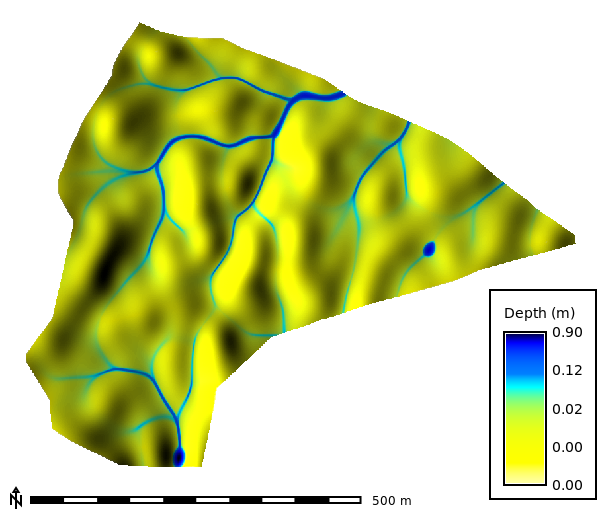

In [255]:
gs.run_command('g.region', raster='elevation_1', flags='ap')
gs.run_command('r.univar', map='elevation_1', flags='e')
res = 1
scalar = '4'
raster = f'depth_{res}_{scalar}_s_30_average'
errorMap = gj.Map()
relief_map = f"elevation_{res}_relief"
errorMap.d_shade(
        color=f"depth_{res}_{scalar}_s_30_average",
        shade=relief_map,
        brighten=30,
        overwrite=True,
    )
errorMap.d_legend(
        title=f"Depth (m)",
        raster=f"depth_{res}_{scalar}_s_30_average",
        at=(5, 35, 84, 91),
        flags="bsl",
        fontsize=14,
    )
errorMap.d_barscale(at=(1, 5), flags="n")
errorMap.show()

In [ ]:
# !g.extension extension=r.tri
# !g.extension extension=r.mapcalc.tiled

Fetching <r.mapcalc.tiled> from <https://github.com/OSGeo/grass-addons/>
(be patient)...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 24 (delta 0), reused 1 (delta 0), pack-reused 14 (from 1)
Receiving objects: 100% (24/24), 20.81 KiB | 20.81 MiB/s, done.
Already on 'grass8'
Your branch is up to date with 'origin/grass8'.
Compiling...
Installing...
Updating extensions metadata file...
Updating extension modules metadata file...
Installation of <r.mapcalc.tiled> successfully finished


total null and non-null cells: 701111
total null cells: 410579

Of the non-null cells:
----------------------
n: 290532
minimum: 0.00107956
maximum: 0.223656
range: 0.222576
mean: 0.0868884
mean of absolute values: 0.0868884
standard deviation: 0.0382783
variance: 0.00146523
variation coefficient: 44.0545 %
sum: 25243.8602218628
1st quartile: 0.0584641
median (even number of cells): 0.0821266
3rd quartile: 0.112083
90th percentile: 0.140282


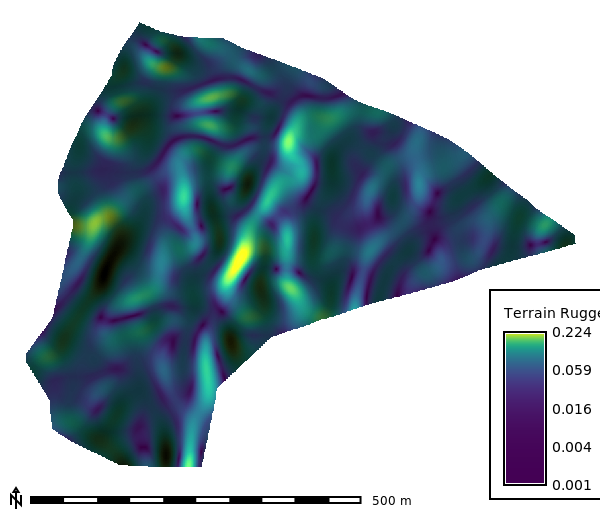

In [260]:
# Terrain Ruggedness Index
gs.run_command("r.tri", input="elevation_1", output="tri_1", processes=4, overwrite=True)
gs.run_command('r.univar', map='tri_1', flags='e')
errorMap = gj.Map()
errorMap.d_shade(
        color="tri_1",
        shade=relief_map,
        brighten=30,
        overwrite=True,
    )
errorMap.d_legend(
        title=f"Terrain Ruggedness Index",
        raster="tri_1",
        at=(5, 35, 84, 91),
        flags="bsl",
        fontsize=14,
    )
# errorMap.d_text(text="30", size="18", at="80,80", color="black" , bgcolor="none")
errorMap.d_barscale(at=(1, 5), flags="n")
errorMap.show()

In [259]:
# !g.list type=raster mapset=basic
!r.surf.area map=elevation units=kilometers

   0  11  22  33  44  55  66  77  88  99Null value area ignored in calculation: 0.405985
Plan area used in calculation: 0.699432
Surface area calculation(low, high, avg):
	0.295440 0.296133 0.295786
Current region plan area: 0.701111
Estimated region Surface Area: 0.296496


In [257]:
analysis_metadata = os.path.join("../output", site, mapset, 'sensitivity_analysis_1.csv')

df_metadata = pd.read_csv(analysis_metadata)
df_metadata['area_m2'] = df_metadata['cells'] * df_metadata['resolution'] ** 2
df_metadata['area_km2'] = df_metadata['area_m2'] / 1e6
df_metadata["p_density"] = df_metadata["particles"] / df_metadata["cells"]
df_metadata["error"] = 1.0 / np.sqrt(df_metadata["particles"])
df_metadata["tri"] = 0.028
df_metadata.to_csv(os.path.join("../output", site, mapset, 'metadata_analysis_1.csv'))
df_metadata.head(50)

,site_name,resolution,scalar,cells,particles,run_n,run_time,area_m2,area_km2,p_density,error,tri
0,SJER,1,0.25,293592,73398.0,0,37.116496,293592,0.293592,0.25,0.003691,0.028
1,SJER,1,0.25,293592,73398.0,1,38.866221,293592,0.293592,0.25,0.003691,0.028
2,SJER,1,0.25,293592,73398.0,2,49.714063,293592,0.293592,0.25,0.003691,0.028
3,SJER,1,0.25,293592,73398.0,3,45.413891,293592,0.293592,0.25,0.003691,0.028
4,SJER,1,0.25,293592,73398.0,4,42.760461,293592,0.293592,0.25,0.003691,0.028
5,SJER,1,0.25,293592,73398.0,5,41.257440,293592,0.293592,0.25,0.003691,0.028
6,SJER,1,0.25,293592,73398.0,6,40.752074,293592,0.293592,0.25,0.003691,0.028
7,SJER,1,0.25,293592,73398.0,7,43.752652,293592,0.293592,0.25,0.003691,0.028
8,SJER,1,0.25,293592,73398.0,8,43.479351,293592,0.293592,0.25,0.003691,0.028
9,SJER,1,0.25,293592,73398.0,9,42.811629,293592,0.293592,0.25,0.003691,0.028


In [112]:
df_grouped = (
    df_metadata
        .groupby(by=['resolution', 'scalar'])
        .agg({
            'run_time': 'mean',
            'particles': 'mean',
            'cells': 'max',
            'area_km2': 'max',
            'p_density': 'max',
            'error': "mean"
        })
        .reset_index()
)

df_grouped.head(20)

,resolution,scalar,run_time,particles,cells,area_km2,p_density,error
0,1,0.25,542.136572,381147.75,1524591,1.524591,0.25,0.001620
1,1,0.50,539.441388,762295.50,1524591,1.524591,0.50,0.001145
2,1,1.00,1049.758717,1524591.00,1524591,1.524591,1.00,0.000810
3,1,2.00,1572.002470,3049182.00,1524591,1.524591,2.00,0.000573
4,1,4.00,5256.450830,6098364.00,1524591,1.524591,4.00,0.000405
5,3,0.25,20.649842,42349.75,169399,1.524591,0.25,0.004859
6,3,0.50,20.709605,84699.50,169399,1.524591,0.50,0.003436
7,3,1.00,41.896683,169399.00,169399,1.524591,1.00,0.002430
8,3,2.00,61.670119,338798.00,169399,1.524591,2.00,0.001718
9,3,4.00,99.613497,677596.00,169399,1.524591,4.00,0.001215


In [109]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   resolution  25 non-null     int64  
 1   scalar      25 non-null     float64
 2   run_time    25 non-null     float64
 3   particles   25 non-null     float64
 4   cells       25 non-null     int64  
 5   area_km2    25 non-null     float64
 6   p_density   25 non-null     float64
 7   error       25 non-null     float64
dtypes: float64(6), int64(2)
memory usage: 1.7 KB


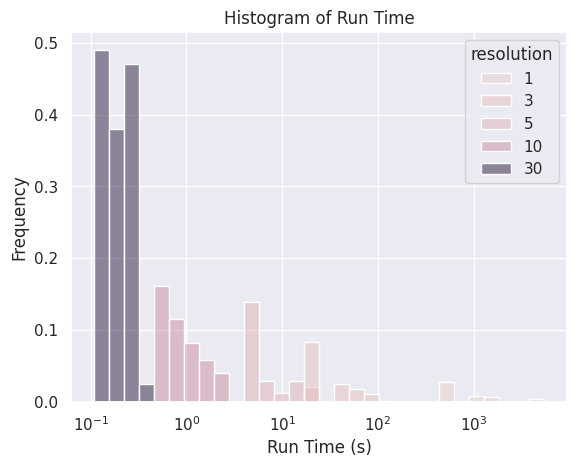

In [119]:
sns.color_palette("crest", as_cmap=True)
sns.histplot(
    data=df_metadata,
    x="run_time",
    hue="resolution",
    weights="error",
    bins=30,
    log_scale=(True, False),
    color="blue"
)
plt.xlabel("Run Time (s)")
plt.ylabel("Frequency")
# plt.legend(title="Particle Density")
plt.title("Histogram of Run Time")
plt.show()

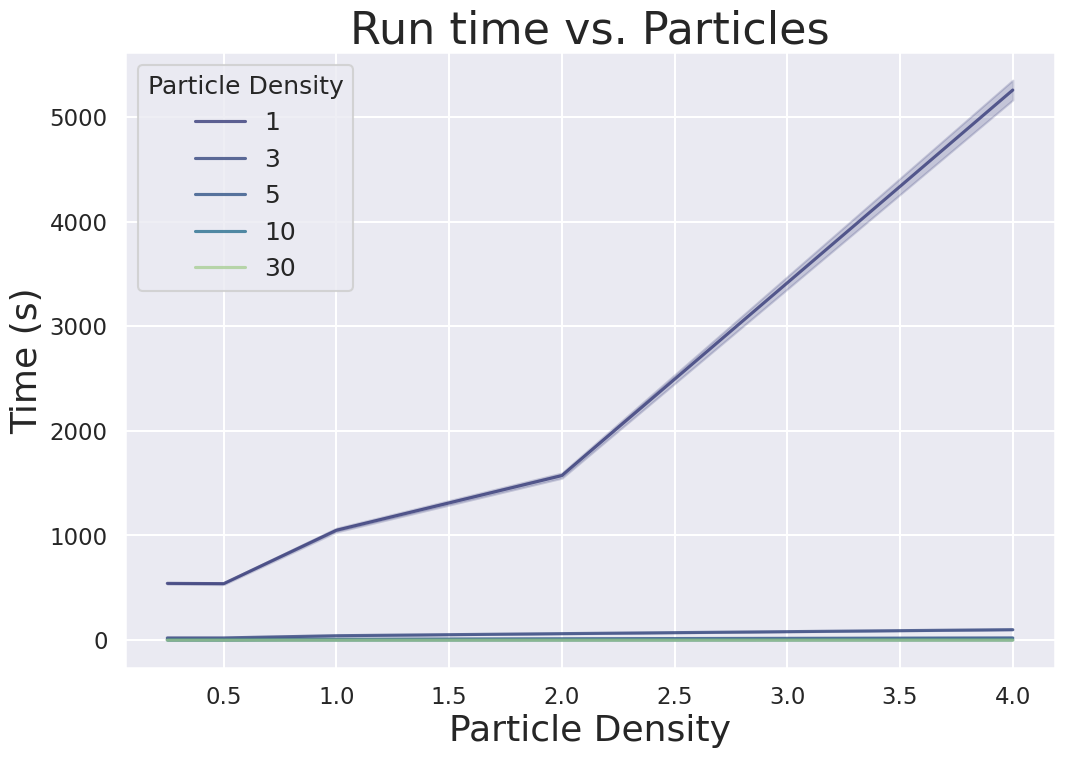

In [123]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=df_metadata,
    x="p_density",
    y="run_time",
    hue="resolution",
    palette="crest_r",
    weights='error',
    alpha=0.75,
    errorbar=('ci', 95)
)
plt.xlabel("Particle Density", fontsize=26)
plt.ylabel("Time (s)", fontsize=26)
plt.title("Run time vs. Particles", fontsize=32)
plt.legend(title="Particle Density", fontsize=18)
plt.savefig(os.path.join("../output", site, mapset, f'{site}_run_time_res_line_plot.png'))

# plt.savefig(f"../output/{site}/{mapset}/{site}_run_time_res_line_plot.png")
plt.show()

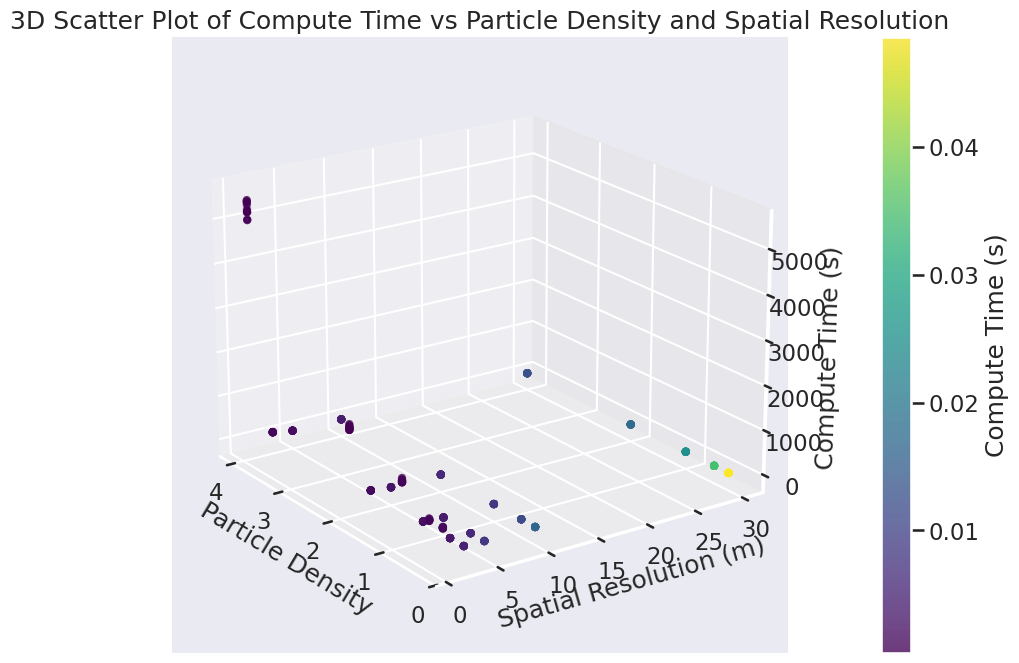

In [129]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
sc = ax.scatter(
    df_metadata['p_density'],
    df_metadata['resolution'],
    df_metadata['run_time'],
    c=df_metadata['error'],
    cmap='viridis',
    alpha=0.75,
    marker='o'
)

# Add color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Compute Time (s)')

# Set labels
ax.set_xlabel('Particle Density')
ax.set_ylabel('Spatial Resolution (m)')
ax.set_zlabel('Compute Time (s)')

# Reverse the order of the x-axis labels
ax.invert_xaxis()

# Set view angle
ax.view_init(elev=20., azim=-35, roll=0)

plt.title('3D Scatter Plot of Compute Time vs Particle Density and Spatial Resolution')
plt.show()

<Axes: xlabel='resolution', ylabel='run_time'>

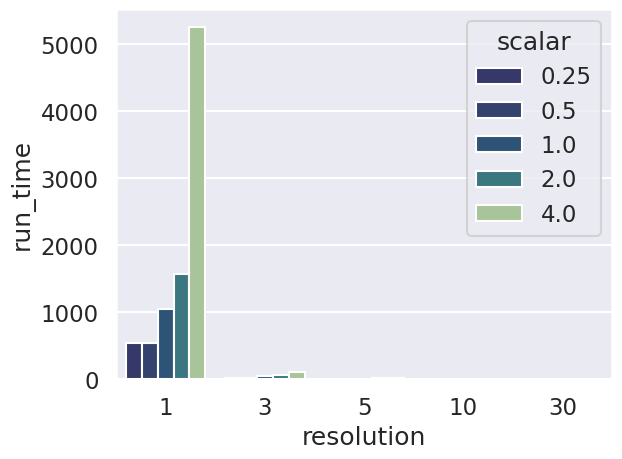

In [133]:
sns.barplot(
    df_grouped, #.query("resolution > 1"),
    x="resolution",
    y="run_time",
    hue="scalar",
    palette="crest_r",
    # width=.4, 
    # palette="vlag"
)

Text(34.08333333333333, 0.5, 'Particle Density')

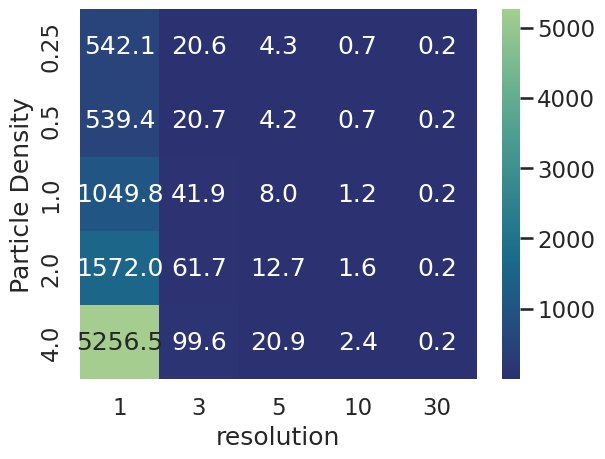

In [144]:
df_metadata_pivot = df_metadata.pivot_table(index="p_density", columns="resolution", values="run_time")
sns.heatmap(
    df_metadata_pivot,
    annot=True,
    fmt=".1f",
    cmap="crest_r"
)

plt.ylabel("Particle Density")

In [ ]:
!g.remove -f type=raster pattern="*_01m*"

In [406]:
def get_simwe_time_steps(search_pattern):
    """Returns a list of time steps from the SIMWE output as """
    timestep_list = gs.read_command(
        "g.list",
        type="raster",
        pattern=search_pattern,
        separator="comma",
    ).strip()
    # print(timestep_list)
    time_steps = [str(t.split(".")[-1]) for t in timestep_list.split(",")]
    # print(time_steps)
    def filter_subset(x):
        # print(x)
        if "_01m" not in x:
            return x

    time_steps_filtered = filter(lambda x: filter_subset(x), time_steps)
    return sorted(list(set(time_steps_filtered)))

res = "30"
scalar_str = "025"
method = "average"
methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
test_list =  get_simwe_time_steps(f"depth_{res}_{scalar_str}_*.*")
print(test_list)

['05', '10', '15', '20', '25', '30']


In [407]:
for step in test_list:
    # print(step)
    # Get list of maps for the current time step
    search_pattern = f"depth_{res}_{scalar_str}_*.{step}"
    depth_list = gs.read_command(
        "g.list",
        type="raster",
        pattern=search_pattern,
        separator="comma",  # noqa: E501
    ).strip()

    strds_name = f"depth_{res}_{scalar_str}_s_{method}"

    if depth_list:
        print(f"Time step {step} has {len(depth_list.split(','))} maps")
        print(depth_list)

        depth_simwe_methods = "average,median,minimum,maximum"
        depth_series_outputs = ",".join(
            [
                f"depth_{res}_{scalar_str}_s_{step}_{m}"
                for m in depth_simwe_methods.split(",")
            ]
        )
        last_depth_time_step = depth_list.split(',')[-1]
        print(f"last_depth_time_step: {last_depth_time_step}")
        print(depth_series_outputs)

      

Time step 05 has 10 maps
depth_30_025_0.05,depth_30_025_1.05,depth_30_025_2.05,depth_30_025_3.05,depth_30_025_4.05,depth_30_025_5.05,depth_30_025_6.05,depth_30_025_7.05,depth_30_025_8.05,depth_30_025_9.05
last_depth_time_step: depth_30_025_9.05
depth_30_025_s_05_average,depth_30_025_s_05_median,depth_30_025_s_05_minimum,depth_30_025_s_05_maximum
Time step 10 has 10 maps
depth_30_025_0.10,depth_30_025_1.10,depth_30_025_2.10,depth_30_025_3.10,depth_30_025_4.10,depth_30_025_5.10,depth_30_025_6.10,depth_30_025_7.10,depth_30_025_8.10,depth_30_025_9.10
last_depth_time_step: depth_30_025_9.10
depth_30_025_s_10_average,depth_30_025_s_10_median,depth_30_025_s_10_minimum,depth_30_025_s_10_maximum
Time step 15 has 10 maps
depth_30_025_0.15,depth_30_025_1.15,depth_30_025_2.15,depth_30_025_3.15,depth_30_025_4.15,depth_30_025_5.15,depth_30_025_6.15,depth_30_025_7.15,depth_30_025_8.15,depth_30_025_9.15
last_depth_time_step: depth_30_025_9.15
depth_30_025_s_15_average,depth_30_025_s_15_median,depth_30

In [46]:
# !t.list type=strds where="mapset = 'sensitivity_1'"
# depth_30_025_s_05_01m
res = "30"
scalar_str = "4" #"025"  0.5, 1, 2, 4
method = "median"
methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
# Average SWIME Simulation STRDS from 10 SIMWE simulations
depth_average = f"depth_{res}_{scalar_str}_s_median"
disch_average = f"discharge_{res}_{scalar_str}_s_average"

# Single SWIME Simulation STRDS
depth_single_run = f"depth_sum_{res}_{scalar_str}"
disch_single_run = f"depth_sum_{res}_{scalar_str}"

# def filter_subset(x):
#     if "_01m" in x:
#         return x
    
# for method in methods.split(","):
#     depth_average = f"depth_{res}_{scalar_str}_s_{method}"
#     umaps=f"depth_30_{scalar_str}_s_05_01m_{method},depth_30_{scalar_str}_s_05_{method},depth_30_{scalar_str}_s_09_01m_{method},depth_30_{scalar_str}_s_09_{method},depth_30_{scalar_str}_s_14_01m_{method},depth_30_{scalar_str}_s_14_{method},depth_30_{scalar_str}_s_18_01m_{method},depth_30_{scalar_str}_s_18_{method},depth_30_{scalar_str}_s_23_01m_{method},depth_30_{scalar_str}_s_23_{method},depth_30_{scalar_str}_s_28_01m_{method},depth_30_{scalar_str}_s_28_{method}".split(",")
#     remove_list = ",".join(filter(lambda x: filter_subset(x), umaps))
#     print(remove_list)
#     !t.unregister type=raster input={depth_average} maps={remove_list}
#     !t.unregister type=raster maps={remove_list}

# gs.run_command("t.info", input=depth_average)

In [409]:
df_grouped.query(f"resolution == 30 and scalar == {scalar_str.replace('0', '0.')}")["run_time"].values[0]

0.23101544380187983

In [410]:
!t.rast.univar -e {depth_average}


id|semantic_label|start|end|mean|min|max|mean_of_abs|stddev|variance|coeff_var|sum|null_cells|cells|non_null_cells|first_quartile|median|third_quartile
depth_30_4_s_05_median@sensitivity_1||2024-01-01 00:00:00|2024-01-01 00:05:00|0.0139704764864548|0.00384972826577723|0.0598659068346024|0.0139704764864548|0.00771499863568618|5.95212039486397e-05|55.2235898551227|19199.6258353349|226936|1374300|1374300|0.00907079|0.0115687|0.0163887|0.0245021
depth_30_4_s_10_median@sensitivity_1||2024-01-01 00:05:00|2024-01-01 00:10:00|0.0188213165685688|0.00384972826577723|0.125715613365173|0.0188213165685688|0.0166263927515449|0.000276436935928625|88.3380962802071|25866.1353601841|226936|1374300|1374300|0.00939398|0.0128209|0.0202721|0.0406093
depth_30_4_s_15_median@sensitivity_1||2024-01-01 00:10:00|2024-01-01 00:15:00|0.0218592980201402|0.00384972826577723|0.177329942584038|0.0218592980201402|0.0242664943275375|0.000588862746948409|111.012230608592|30041.2332690787|226936|1374300|1374300|0.00939398|

In [286]:
def univar_stats_df(raster_list, res, scalar_str, method, ars):
    stats_list = []
    for raster in raster_list.split(","):
        gs.run_command("g.region", raster=raster, flags="a")
        stats = gs.parse_command("r.univar", map=raster, format="json", flags="e")[0]

        
        extra_stats = df_grouped.query(f"resolution == {res} and scalar == {scalar_str.replace('0', '0.')}")
        stats["run_time"] = extra_stats["run_time"].values[0]
        stats["particles"] = extra_stats["particles"].values[0]
        stats["area_km2"] = extra_stats["area_km2"].values[0]
        stats["resolution"] = res
        stats["scalar"] = scalar_str
        stats["minute"] = raster.split("_")[4]
        stats["stat_type"] = method
        stats["ars"] = ars
        stats_list.append(stats)
    
    return pd.DataFrame(stats_list)

# raster_depth_list = gs.read_command(
#         "g.list", type="raster", pattern="depth_sum_*_*_*_stats_*", separator="comma"  # noqa: E501
# ).strip()



model_spatial_res_params = ["1", "3", "5", "10", "30"]  # meters
model_particle_density_scalar_params = ["025", "05", "1", "2", "4"]
methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
dataframe_list = []
for res in model_spatial_res_params:
    ars_map = f"ars_{res}"
    gs.run_command("g.region", raster=f"elevation_{res}", flags="a")
    gs.run_command("r.tri", input=f"elevation_{res}", output=ars_map, size=5, processes=6, overwrite=True)
    json_data = gs.parse_command('r.univar', map=ars_map, format='json')
    ars = json_data[0]['mean']

    for scalar_str in model_particle_density_scalar_params:
        for method in methods.split(","):
            depth_average = f"depth_{res}_{scalar_str}_s_{method}"
            raster_depth_list = gs.parse_command(
                "t.rast.list",
                input=depth_average,
                format="json"
            )
            raster_depth_list= ",".join([m['name'] for m in raster_depth_list['data']])
            depth_stats_df = univar_stats_df(raster_depth_list, res, scalar_str, method, ars)
            dataframe_list.append(depth_stats_df)
            # depth_stats_df.head()

result_vertical = pd.concat(dataframe_list)


In [288]:
# result_vertical["minute"] = result_vertical["minute"].astype(int)
# Compute the error
result_vertical["error"] = 1.0 / np.sqrt(result_vertical["particles"])

# Normalize the error relative to the base case (e.g., scalar = 1)
base_error = result_vertical[result_vertical["scalar"] == '1']["error"].values
result_vertical["run_id"] = result_vertical['resolution'].astype(str) + "_" + result_vertical['scalar'].astype(str)
result_vertical["normalized_error"] = result_vertical["error"] / base_error[0]
result_vertical["p_density"] = result_vertical["particles"] / result_vertical["cells"]

result_vertical.to_csv(os.path.join("../output", site, mapset, 'metadata_depth_analysis_1.csv'))

In [603]:
result_vertical.query("stat_type == 'average' and minute == '30'").head()

,n,null_cells,cells,min,max,range,mean,mean_of_abs,stddev,variance,...,percentiles,run_time,particles,area_km2,resolution,scalar,minute,stat_type,error,normalized_error
5,1684,156,1840,0.000425,0.544026,0.543601,0.021187,0.021187,0.058677,0.003443,...,"[{'percentile': 90, 'value': 0.028517968021333...",542.136572,381147.75,1.524591,1,025,30,average,0.001620,2.000000
5,1684,156,1840,0.000654,0.544332,0.543678,0.021185,0.021185,0.058676,0.003443,...,"[{'percentile': 90, 'value': 0.029058113694190...",539.441388,762295.50,1.524591,1,05,30,average,0.001145,1.414214
5,1684,156,1840,0.000601,0.544260,0.543659,0.021202,0.021202,0.058664,0.003441,...,"[{'percentile': 90, 'value': 0.028908204473555...",1049.758717,1524591.00,1.524591,1,1,30,average,0.000810,1.000000
5,1684,156,1840,0.000618,0.544220,0.543601,0.021203,0.021203,0.058676,0.003443,...,"[{'percentile': 90, 'value': 0.028913185186684...",1572.002470,3049182.00,1.524591,1,2,30,average,0.000573,0.707107
5,1684,156,1840,0.000654,0.477567,0.476913,0.021440,0.021440,0.057477,0.003304,...,"[{'percentile': 90, 'value': 0.030096934363245...",5256.450830,6098364.00,1.524591,1,4,30,average,0.000405,0.500000


In [145]:
result_vertical.describe()

,n,null_cells,cells,min,max,range,mean,mean_of_abs,stddev,variance,...,sum,first_quartile,median,third_quartile,run_time,particles,area_km2,error,normalized_error,p_density
count,1.200000e+03,1200.000000,1.200000e+03,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1.200000e+03,...,1.200000e+03,1200.000000,1200.000000,1200.000000,1200.000000,1.200000e+03,1200.000000,1200.000000,1200.000000,1200.000000
mean,3.526984e+05,19703.600000,3.724020e+05,0.000622,2.550596,2.549974,1.085796,1.085796,0.735222,2.060013e+00,...,3.922836e+05,0.491800,0.998381,1.744553,370.476856,5.492933e+05,1.524361,0.008925,11.019999,1.461266
std,5.865787e+05,31225.947853,6.178002e+05,0.001060,3.740066,3.740435,1.860193,1.860193,1.233179,3.568320e+00,...,1.463091e+06,0.850740,1.720198,3.006801,1065.790865,1.307313e+06,0.000375,0.011446,14.133170,1.286503
min,1.527000e+03,313.000000,1.840000e+03,0.000000,0.002588,0.002422,0.000205,0.000205,0.000096,9.174299e-09,...,1.713776e+00,0.000146,0.000187,0.000240,0.154550,4.232500e+02,1.523700,0.000405,0.500000,0.230027
25%,1.473800e+04,1408.000000,1.614600e+04,0.000000,0.059417,0.056813,0.009302,0.009302,0.006844,4.907669e-05,...,1.609001e+02,0.003378,0.005600,0.009208,0.659104,7.621000e+03,1.524200,0.001718,2.121320,0.472005
50%,5.998100e+04,4327.000000,6.430800e+04,0.000147,0.517921,0.516801,0.018729,0.018729,0.036760,1.351263e-03,...,1.249418e+03,0.005446,0.008338,0.013161,8.016080,6.096800e+04,1.524591,0.004050,5.000641,0.948389
75%,1.677150e+05,10765.000000,1.784800e+05,0.000687,3.254163,3.253740,0.933567,0.933567,0.742306,1.959878e+00,...,2.565544e+04,0.260000,0.763414,1.520134,61.670119,3.387980e+05,1.524591,0.011455,14.143949,1.898241
max,1.519531e+06,81705.000000,1.601236e+06,0.005985,9.000000,9.000000,4.478546,4.478546,2.961704,8.771690e+00,...,6.805289e+06,2.000000,4.000000,7.000000,5256.450830,6.098364e+06,1.524725,0.048607,60.017540,3.808535


<Axes: xlabel='resolution', ylabel='mean'>

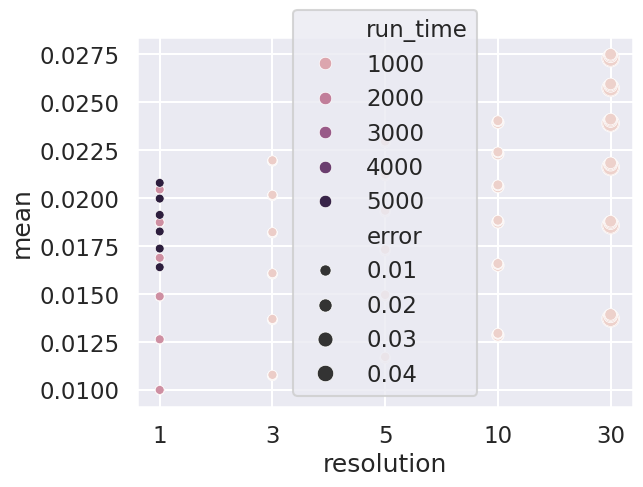

In [159]:
sns.scatterplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="resolution",
    y="mean",
    size="error",
    hue='run_time'
)

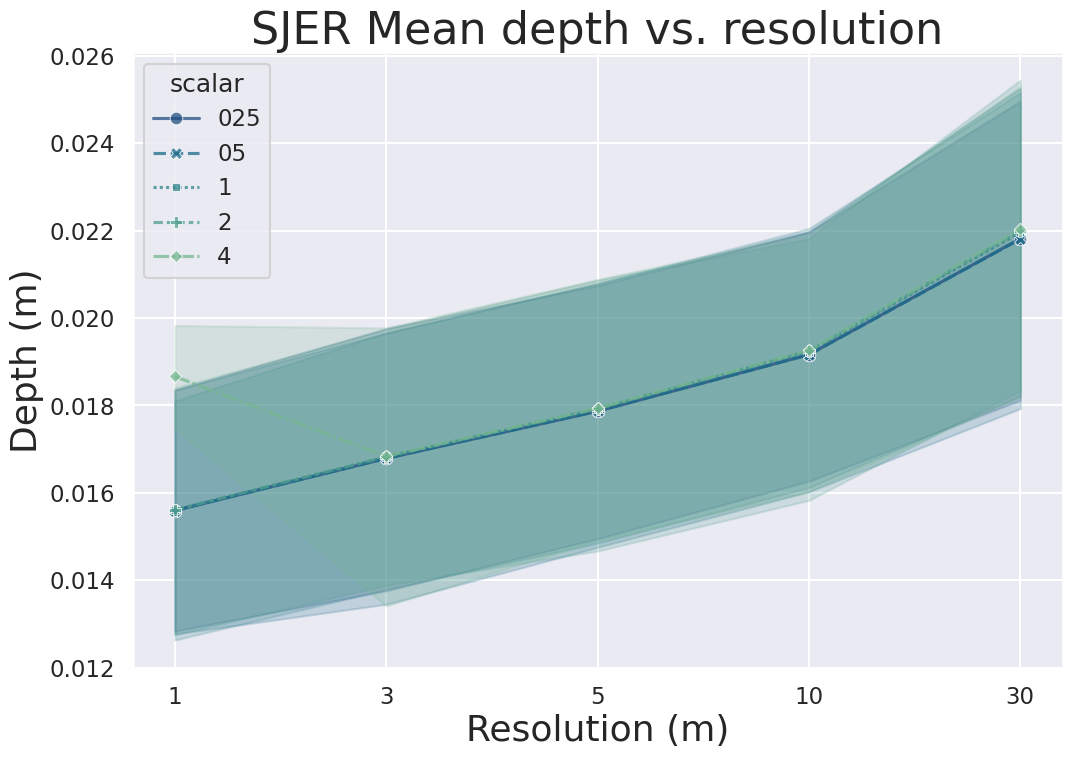

In [155]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="resolution",
    y="mean",
    hue="scalar",
    palette="crest_r",
    alpha=0.75,
    # ax=ax,
    markers=True,
    # kind="line",
    style="scalar"
)

plt.xlabel("Resolution (m)", fontsize=26)
plt.ylabel("Depth (m)", fontsize=26)
plt.title("SJER Mean depth vs. resolution", fontsize=32)
plt.savefig(f"../output/{site}/{mapset}/{site}_mean_depth_res_line_plot.png")
plt.show()

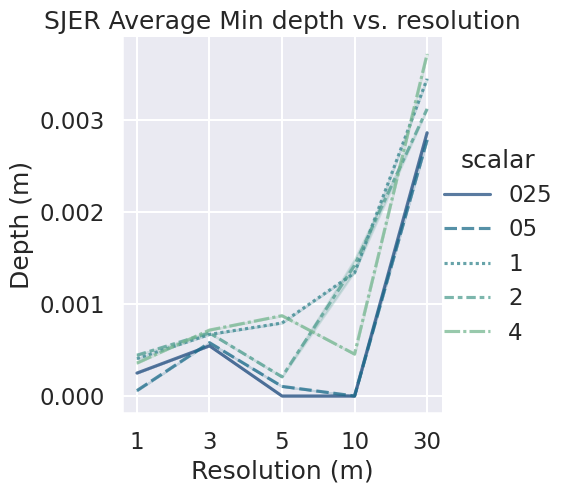

In [52]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="resolution",
    y="min",
    hue="scalar",
    palette="crest_r",
    alpha=0.75,
    # col="stat_type",
    # row="stat_type",
    # errorbar=('ci', 95),
    markers=False,
    kind="line",
    style="scalar"
)

plt.xlabel("Resolution (m)")
plt.ylabel("Depth (m)")
plt.title("SJER Average Min depth vs. resolution")
plt.show()

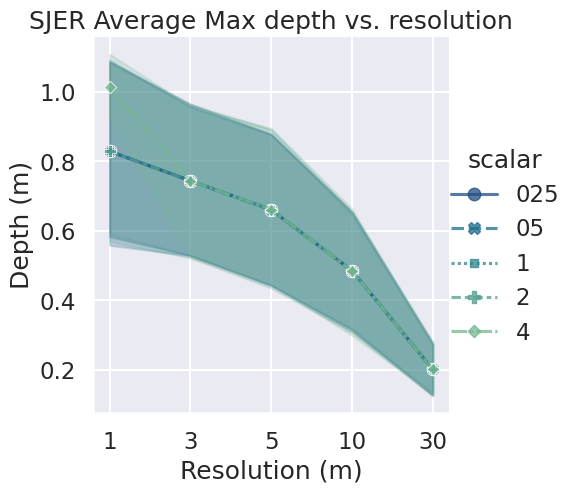

In [53]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="resolution",
    y="max",
    hue="scalar",
    palette="crest_r",
    alpha=0.75,
    # col="stat_type",
    # row="stat_type",
    # errorbar=('ci', 95),
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Resolution (m)")
plt.ylabel("Depth (m)")
plt.title("SJER Average Max depth vs. resolution")
plt.show()

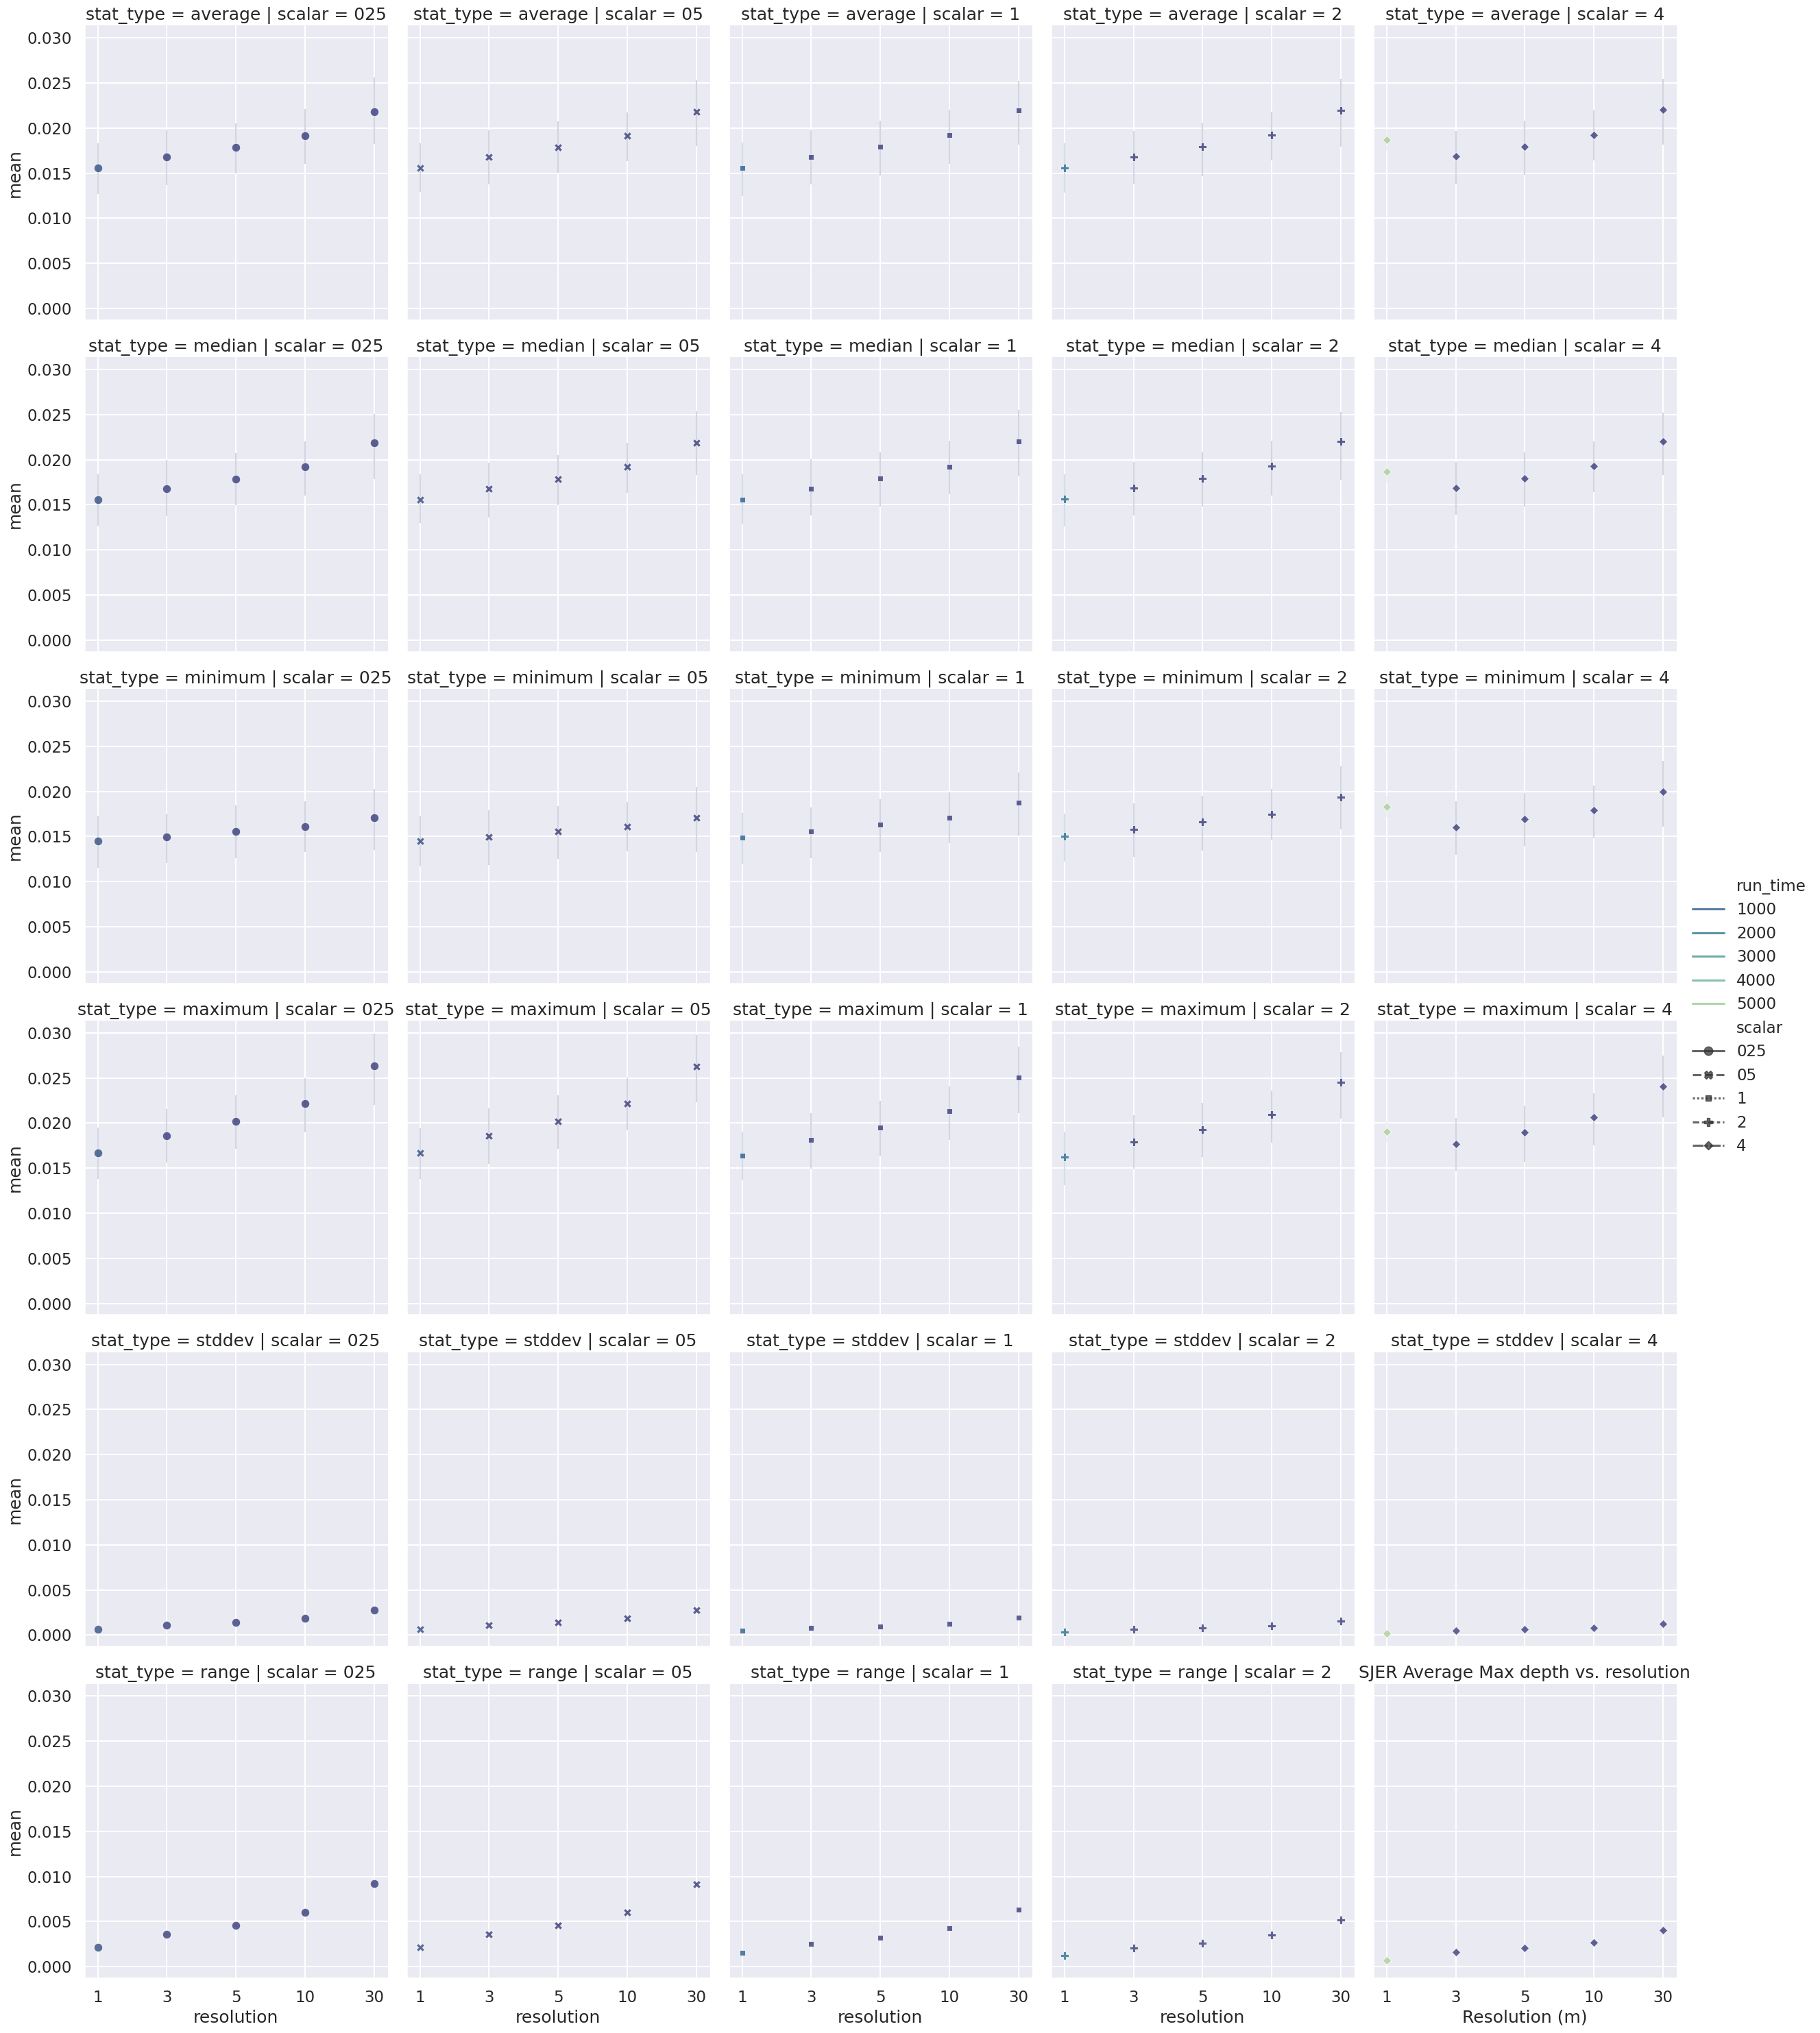

In [160]:
sns.relplot(
    data=result_vertical.query("stat_type != 'max_raster' and stat_type != 'min_raster'"),
    x="resolution",
    y="mean",
    hue="run_time",
    palette="crest_r",
    alpha=0.75,
    col="scalar",
    row="stat_type",
    # errorbar=('ci', 95),
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Resolution (m)")
plt.ylabel("Depth (m)")
plt.title("SJER Average Max depth vs. resolution")
plt.show()

/tmp/ipykernel_6237/2988010422.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(


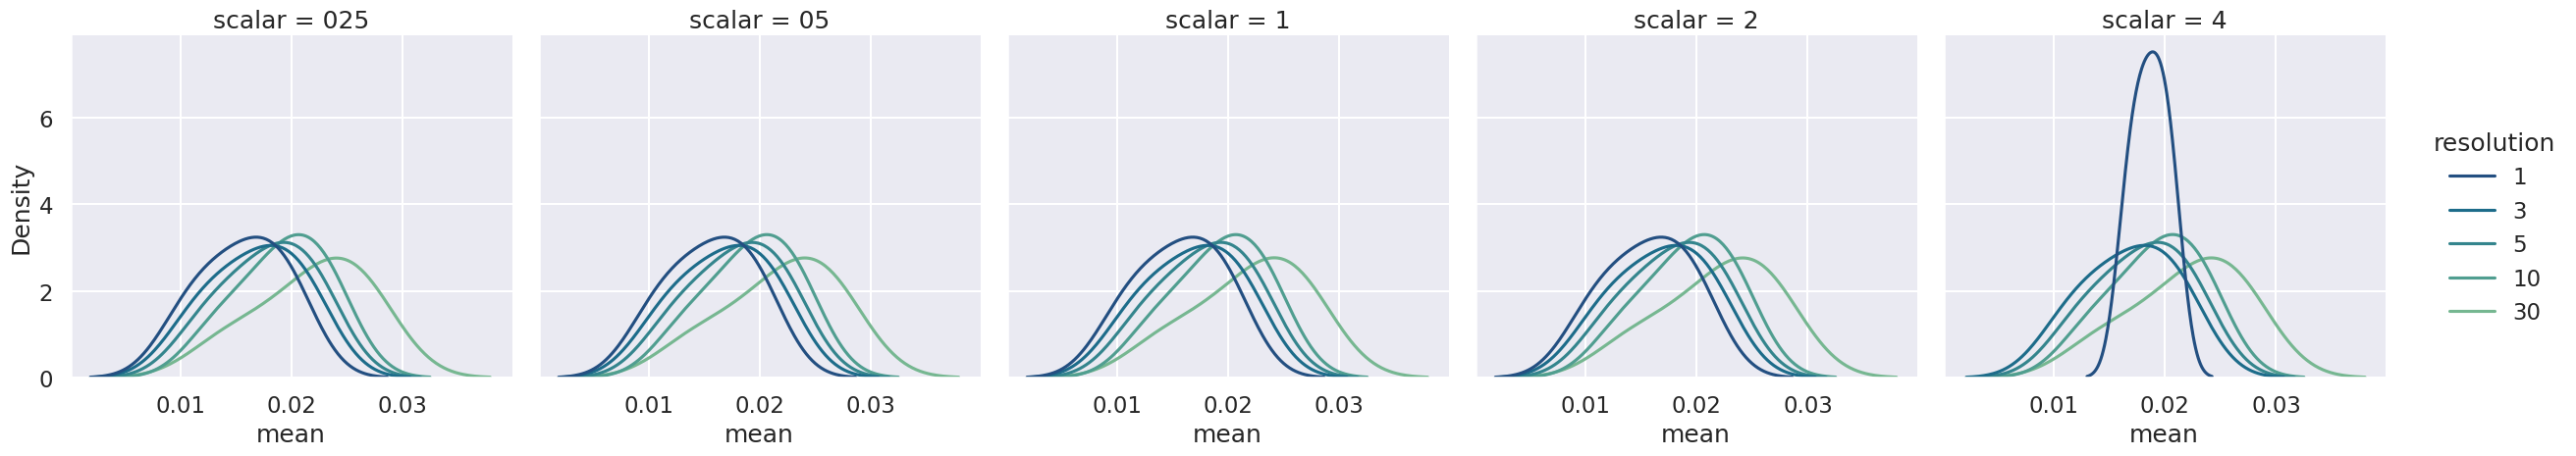

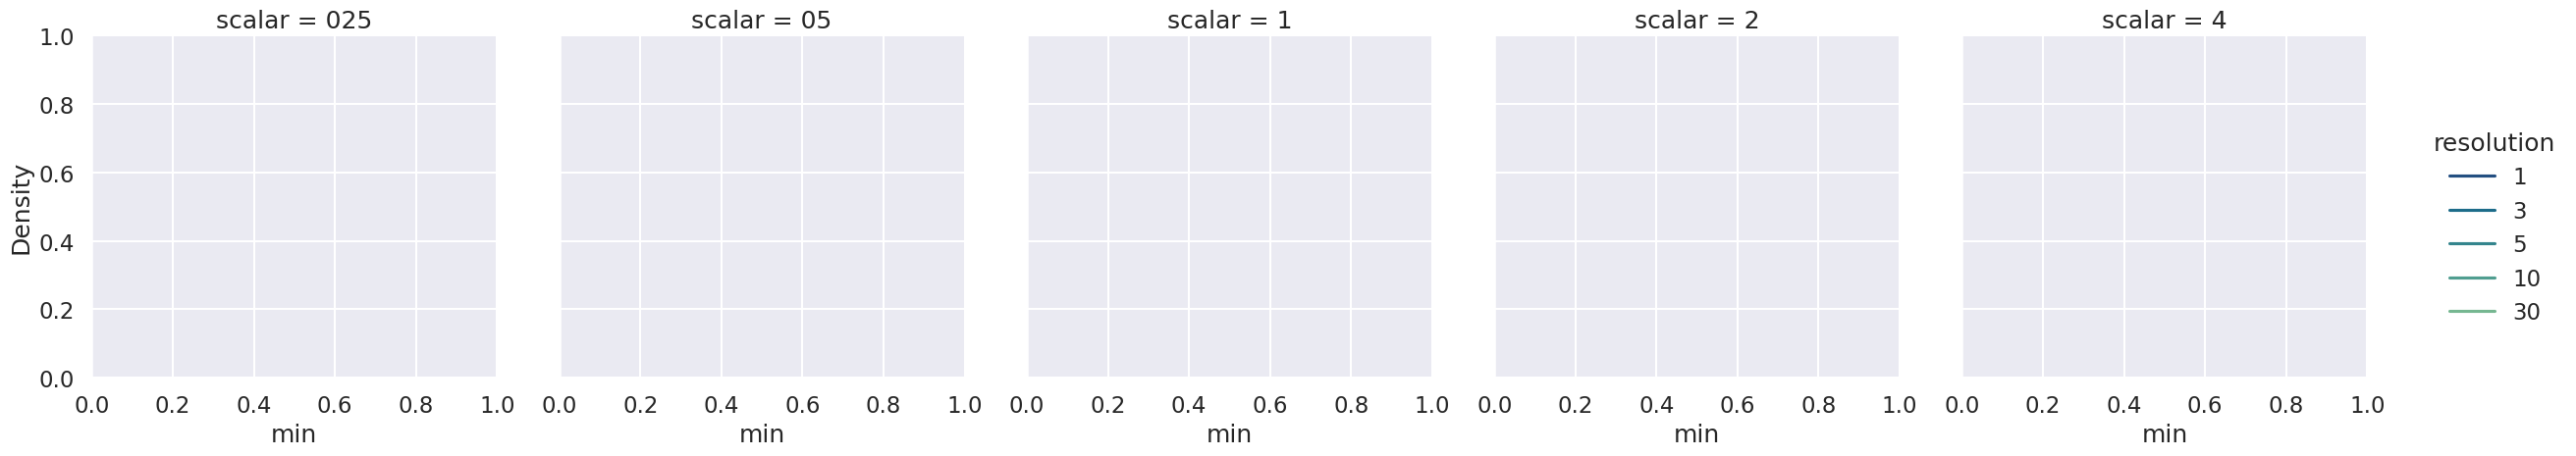

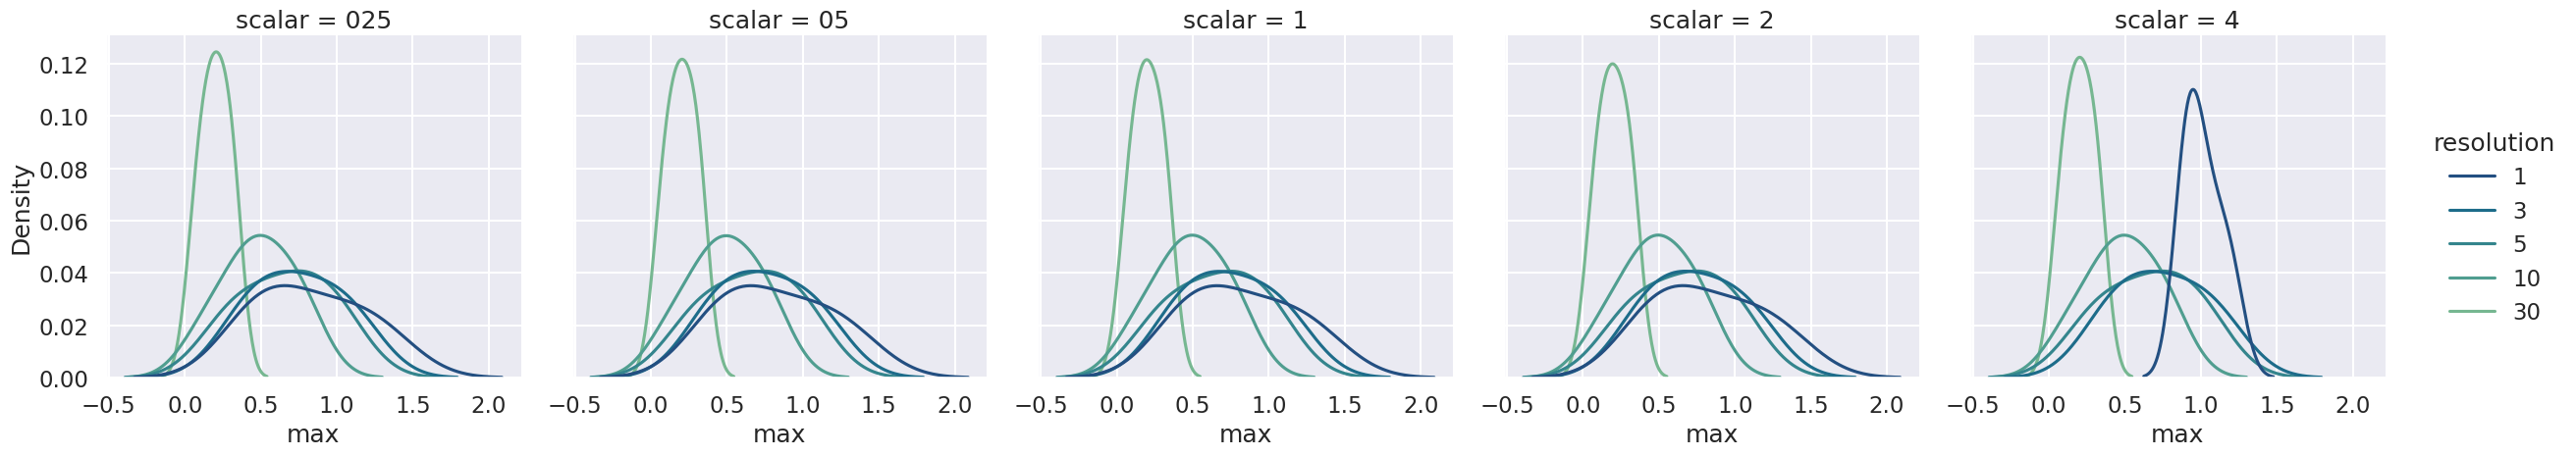

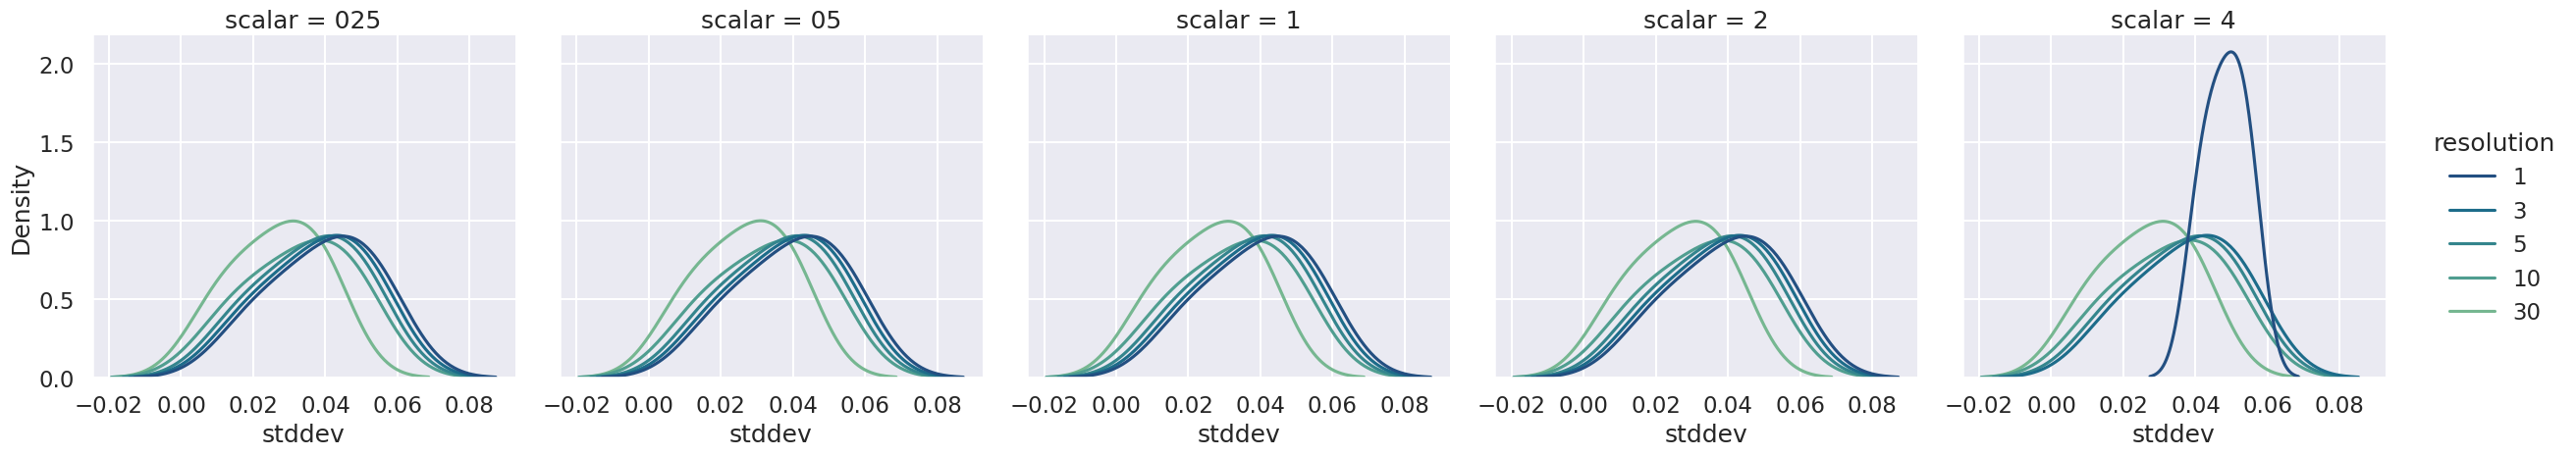

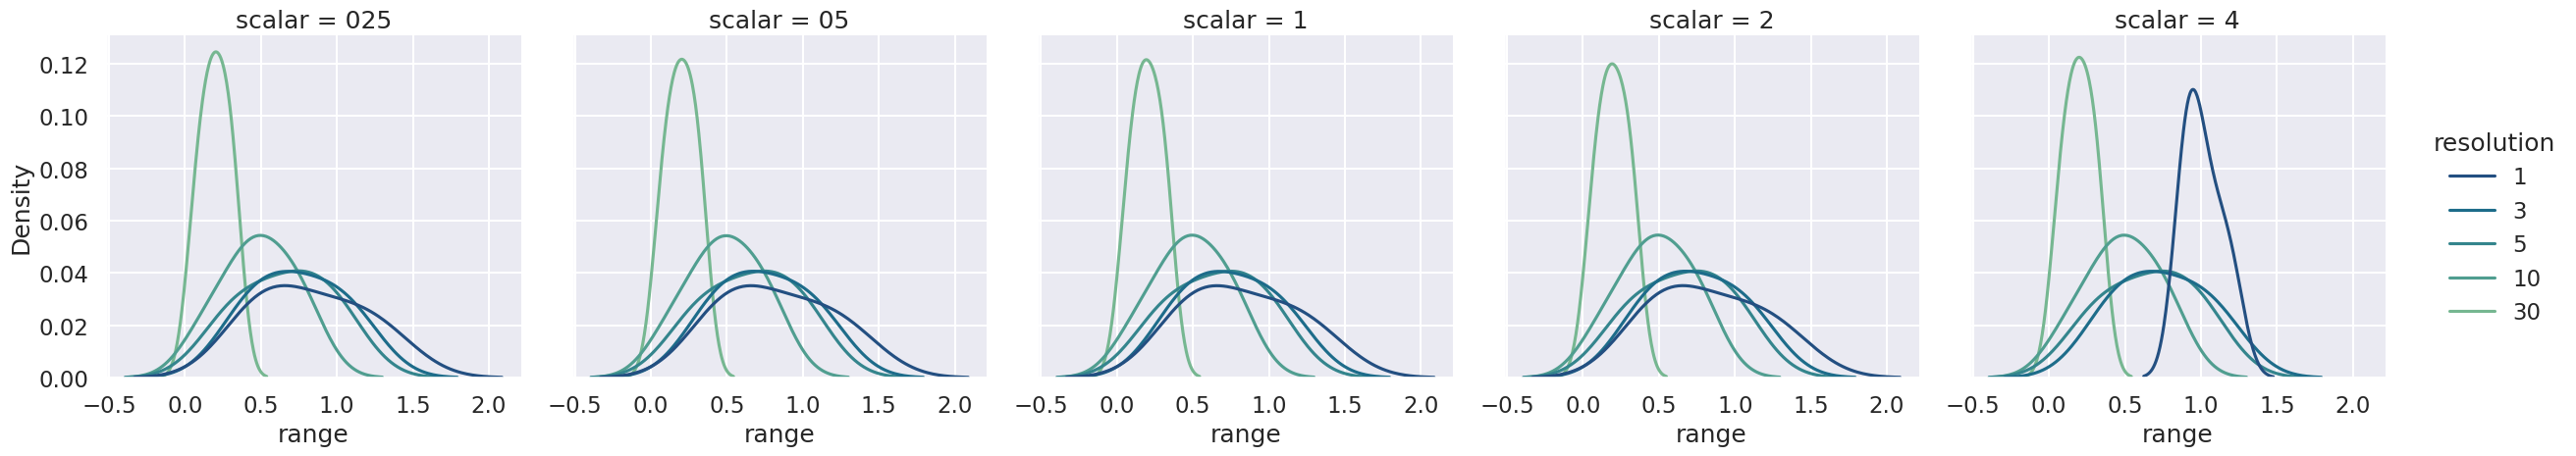

In [55]:
# sns.jointplot(
#     data=result_vertical.query("stat_type == 'average'"),
#     x="mean", y="run_time", hue="resolution",
#     kind="kde"
# )
sns.displot(
    result_vertical.query("stat_type == 'median'"),
    col="scalar",
    x="mean",
    # x="run_time",
    hue="resolution", 
    kind="kde",
    palette="crest_r",
)

sns.displot(
    result_vertical.query("stat_type == 'median'"),
    col="scalar",
    x="min",
    # x="run_time",
    hue="resolution", 
    kind="kde",
    palette="crest_r",
)

sns.displot(
    result_vertical.query("stat_type == 'median'"),
    col="scalar",
    x="max",
    # x="run_time",
    hue="resolution", 
    kind="kde",
    palette="crest_r",
)

sns.displot(
    result_vertical.query("stat_type == 'median'"),
    col="scalar",
    x="stddev",
    # x="run_time",
    hue="resolution", 
    kind="kde",
    palette="crest_r",
)

sns.displot(
    result_vertical.query("stat_type == 'median'"),
    col="scalar",
    x="range",
    # x="run_time",
    hue="resolution", 
    kind="kde",
    palette="crest_r",
)


/tmp/ipykernel_6237/784695162.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(


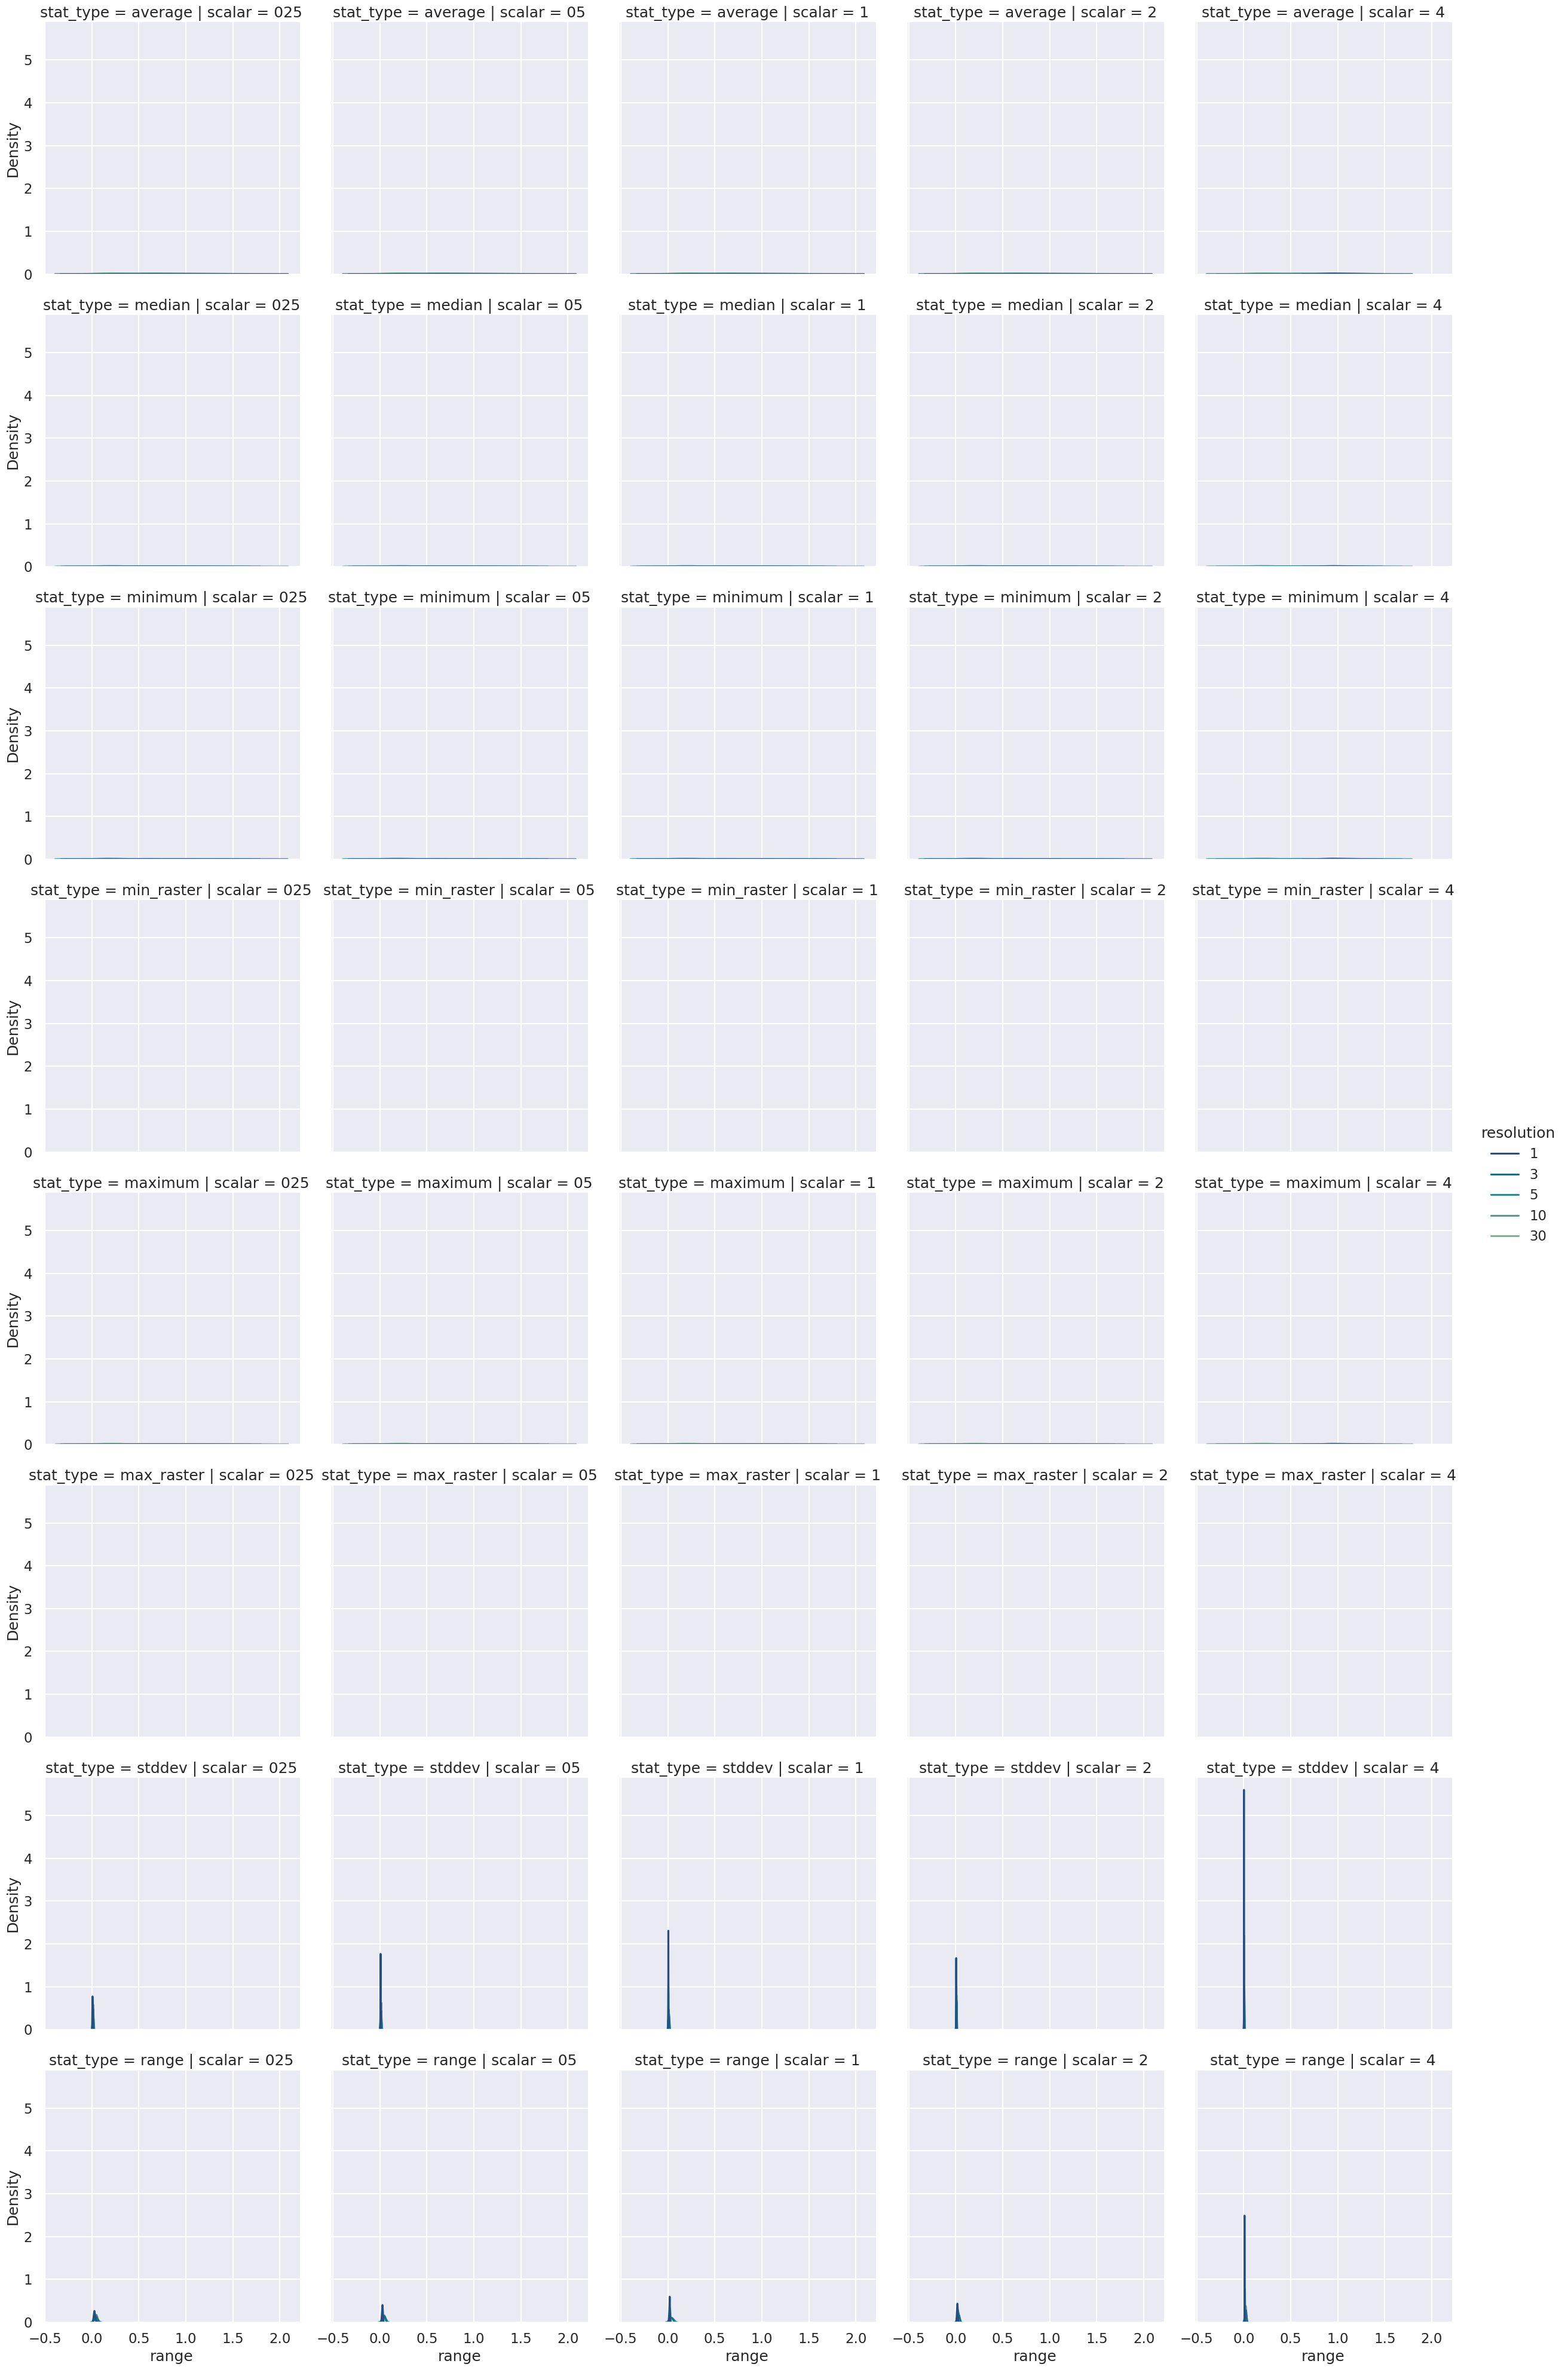

In [56]:
sns.displot(
    result_vertical,
    col="scalar",
    row="stat_type",
    x="range",
    # x="run_time",
    hue="resolution", 
    kind="kde",
    palette="crest_r",
)

/tmp/ipykernel_6237/930961344.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


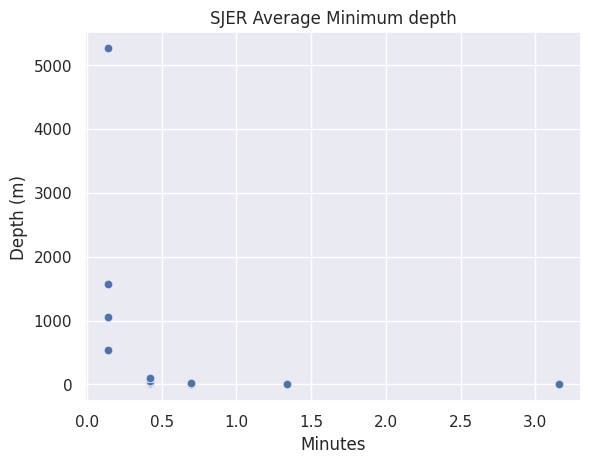

In [322]:
sns.set_context("notebook")
# sns.
sns.scatterplot(
    data=result_vertical, #.query("stat_type == 'average'"),
    x="ars",
    y="run_time",
    # hue="resolution",
    palette="crest_r",
    alpha=0.5,
    # size="run_time",
    # col="scalar",
    # row="resolution",
    # row="stat_type",
    # errorbar=('ci', 95),
    # markers=True,
    # kind="line",
    # style="scalar"
)

plt.xlabel("Minutes")
plt.ylabel("Depth (m)")
plt.title("SJER Average Minimum depth")
plt.show()

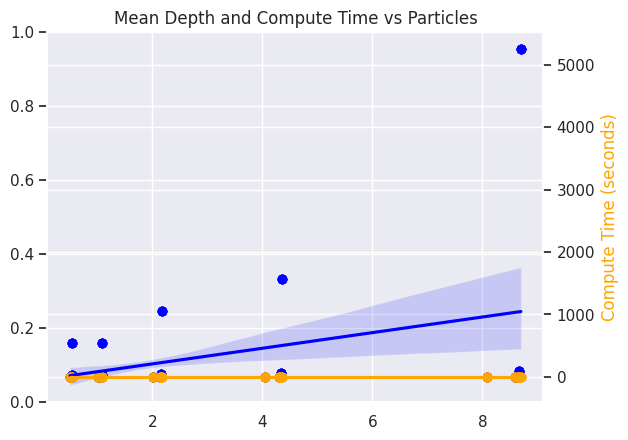

In [290]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df = result_vertical.query("stat_type == 'average'")
# Plot Mean Depth
# ax1.plot(df["p_density"], df["mean"], 'g-', marker='o', label="Mean Depth")
ax1 = sns.regplot(data=df, x="p_density", y="run_time", color="blue")
ax1.set_xlabel("Number of Particles")
ax1.set_ylabel("Mean Depth", color='b')

# Plot Compute Time
# ax2.plot(df["p_density"], df["run_time"], 'b-', marker='s', label="Compute Time")
ax2 = sns.regplot(data=df, x="p_density", y="ars", color='orange')
ax2.set_ylabel("Compute Time (seconds)", color='orange')

plt.title("Mean Depth and Compute Time vs Particles")
plt.show()



Text(46.25, 0.5, 'Particle Density')

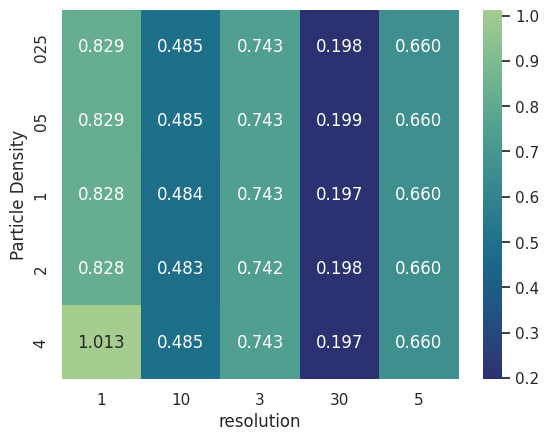

In [95]:
df_metadata_pivot = result_vertical.query("stat_type == 'average'").pivot_table(index="scalar", columns="resolution", values="range")
sns.heatmap(
    df_metadata_pivot,
    annot=True,
    fmt=".3f",
    cmap="crest_r"
)

plt.ylabel("Particle Density")

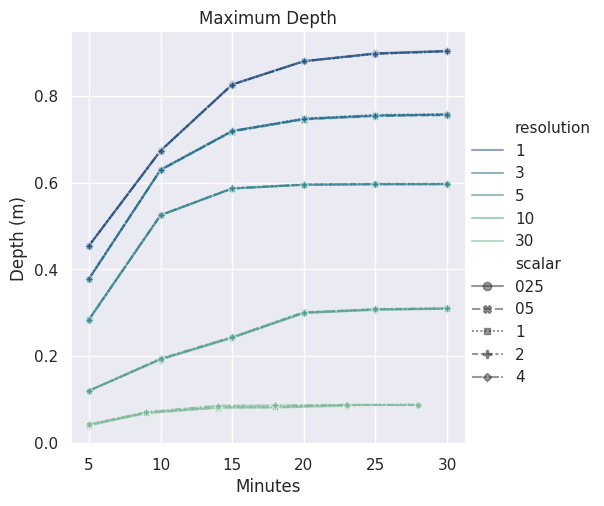

In [330]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x=result_vertical.query("stat_type == 'average'")["minute"].astype(int),
    y="max",
    hue="resolution",
    palette="crest_r",
    alpha=0.5,
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Minutes")
plt.ylabel("Depth (m)")
plt.title("Maximum Depth")
plt.show()

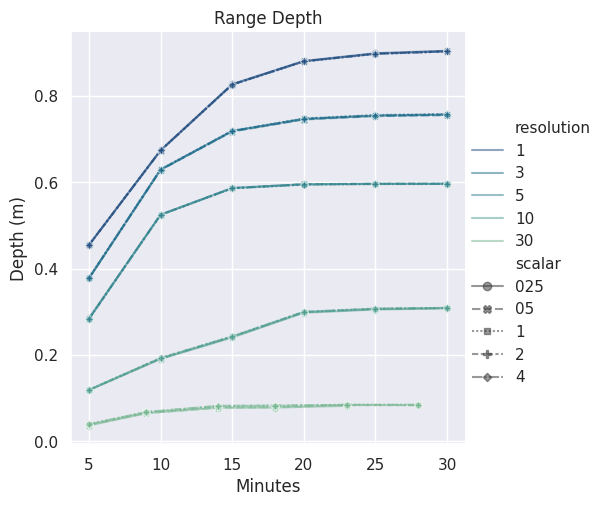

In [333]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x=result_vertical.query("stat_type == 'average'")["minute"].astype(int),
    y="range",
    hue="resolution",
    palette="crest_r",
    alpha=0.5,
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Minutes")
plt.ylabel("Depth (m)")
plt.title("Range Depth")
plt.show()

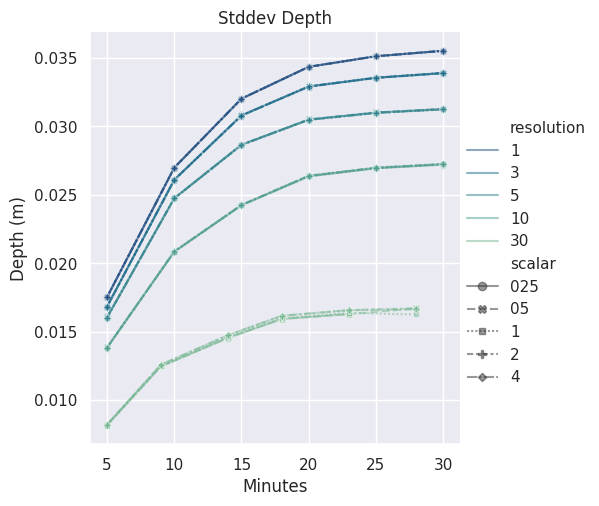

In [ ]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x=result_vertical.query("stat_type == 'average'")["minute"].astype(int),
    y="stddev",
    hue="resolution",
    palette="crest_r",
    alpha=0.5,
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Minutes")
plt.ylabel("Depth (m)")
plt.title("Stddev")
plt.show()

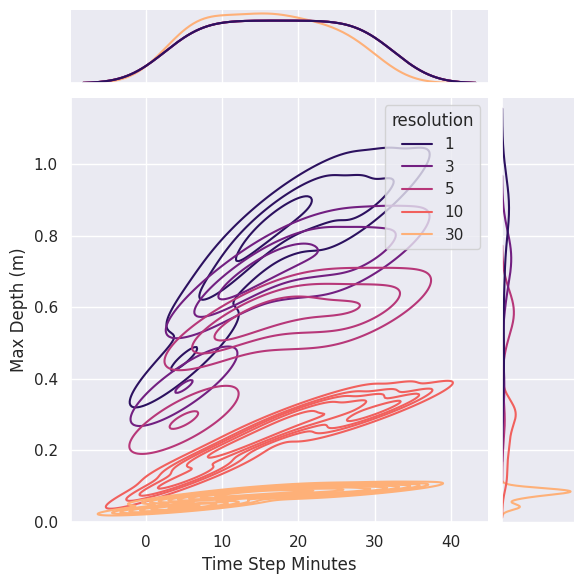

In [321]:
# sns.jointplot(
#     data=result_vertical.query("stat_type == 'median'"),
#     x=result_vertical.query("stat_type == 'median'")["minute"].astype(int),
#     y="max",
#     # hue="resolution",
#     hue="ars",
#     # xlim=[-5,34],
#     kind="kde",
#     palette="crest_r"
# )
# fig, ax = plt.subplots(figsize=(12, 8))
sns.jointplot(
    data=result_vertical.query("stat_type == 'median'"),
    x=result_vertical.query("stat_type == 'median'")["minute"].astype(int),
    y="max",
    hue="resolution",
    kind="kde",
    palette="magma",
)
plt.xlabel("Time Step Minutes")
plt.ylabel("Max Depth (m)")
plt.savefig(f"../output/{site}/{mapset}/{site}_max_depth_res_joint_plot.png")



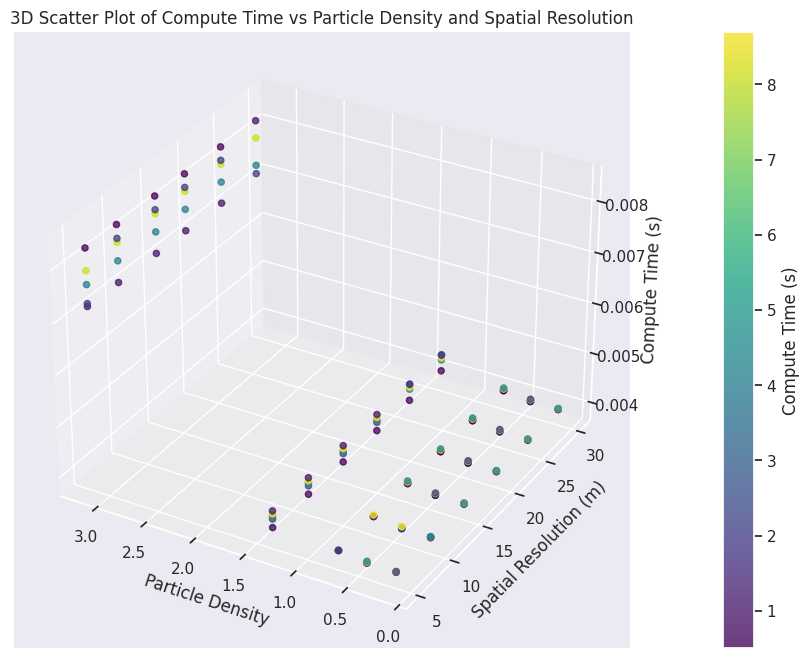

In [292]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
sc = ax.scatter(
    result_vertical.query("stat_type == 'median'")['ars'],
    result_vertical.query("stat_type == 'median'")["minute"].astype(int),
   
    result_vertical.query("stat_type == 'median'")['median'],
    # df_metadata['resolution'],
    # df_metadata['run_time'],
    c=result_vertical.query("stat_type == 'median'")['p_density'],
    cmap='viridis',
    alpha=0.75,
    marker='o'
)

# Add color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Compute Time (s)')

# Set labels
ax.set_xlabel('Particle Density')
ax.set_ylabel('Spatial Resolution (m)')
ax.set_zlabel('Compute Time (s)')

# Reverse the order of the x-axis labels
ax.invert_xaxis()

# Set view angle
# ax.view_init(elev=20., azim=-35, roll=0)

plt.title('3D Scatter Plot of Compute Time vs Particle Density and Spatial Resolution')
plt.show()

<Axes: xlabel='median', ylabel='Count'>

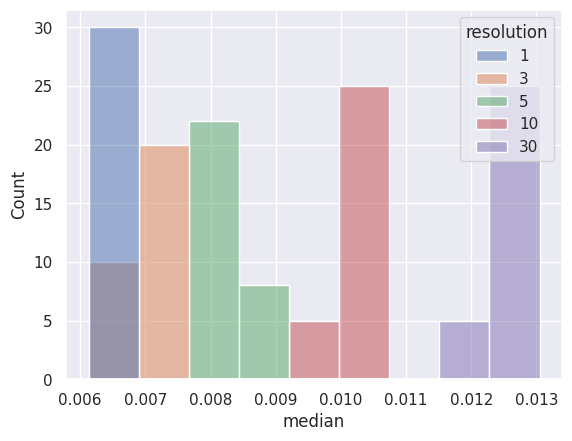

In [222]:
# sns.histplot(
#     data=result_vertical.query("stat_type == 'average'"),
#     x="mean",
#     hue="resolution"
# )

sns.histplot(
    data=result_vertical.query("stat_type == 'median'"),
    x="median",
    hue="resolution"
)

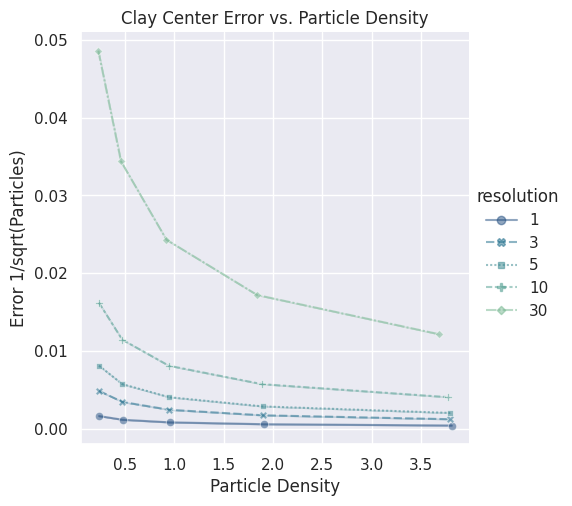

In [201]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    # x="particles",
    x="p_density",
    y="error",
    hue="resolution",
    palette="crest_r",
    alpha=0.5,
    markers=True,
    kind="line",
    style="resolution"
)

plt.xlabel("Particle Density")
plt.ylabel("Error 1/sqrt(Particles)")
plt.title("Clay Center Error vs. Particle Density")
plt.show()

<Axes: xlabel='median', ylabel='Percent'>

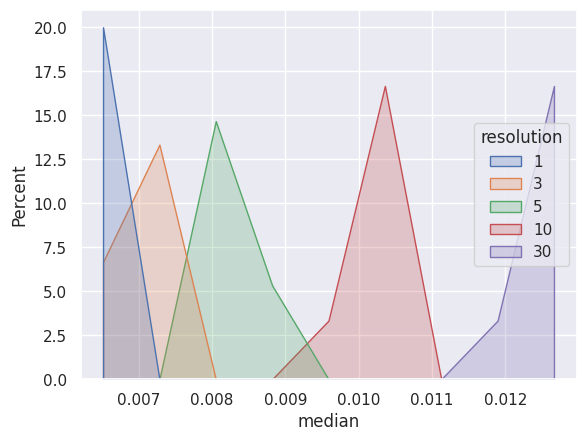

In [227]:
sns.histplot(
    data=result_vertical.query("stat_type == 'median'"),
    x="median",
    hue="resolution",
    element="poly",
    stat="percent"
)


In [2]:
from PIL import Image
import imageio.v3 as iio
import os

def create_webp_animation(input_pngs, output_file, fps=60, loop=0):
    # Get a sorted list of PNG files in the input folder
    png_files = sorted(input_pngs)
    
    if not png_files:
        raise ValueError("No PNG files found in the specified folder.")
    
    # Read images
    images = [Image.open(png) for png in png_files]
    
    # Save as animated WebP
    iio.imwrite(
        output_file,
        [image for image in images],
        plugin="pillow",
        format="webp",
        fps=fps,
        loop=loop,
    )
    
    print(f"Animated WebP saved as {output_file}")

def create_static_map(site, res, scalar, step, method):
    PROJECT_MAPSET = "sensitivity_1"
    # site = "clay-center"
    output_image = f"../output/{site}/{PROJECT_MAPSET}/{site}_depth_{res}_{scalar}_s_{step}_{method}.png"
    dem_map = gj.Map(
        use_region=True,
        height=600,
        width=600,
        filename=output_image,
    )
    relief_map = f"elevation_{res}_relief"

    
    dem_map.d_shade(
        color=f"depth_{res}_{scalar}_s_{step}_{method}",
        shade=relief_map,
        brighten=30,
        overwrite=True,
    )

    # SJER
    dem_map.d_legend(
        title=f"Depth (m)",
        raster=f"depth_{res}_{scalar}_s_{step}_{method}",
        at=(10, 40, 82, 89),
        flags="bs",
        fontsize=14,
    )
    dem_map.d_barscale(at=(1, 12), flags="n")

    # Clay Center
    # dem_map.d_legend(
    #     title=f"Depth (m)",
    #     raster=f"depth_{res}_{scalar}_s_{step}_{method}",
    #     at=(5, 35, 84, 91),
    #     flags="bs",
    #     fontsize=14,
    # )
    # dem_map.d_barscale(at=(1, 7), flags="n")
    
    dem_map.d_text(text=f"{step}", size="18", at="80,80", color="black" , bgcolor="none")

    return output_image

def get_agg_simwe_time_steps(search_pattern):
    """Returns a list of time steps from the SIMWE output as """
    timestep_list = gs.read_command(
        "g.list",
        type="raster",
        pattern=search_pattern,
        separator="comma",
    ).strip()
    # print(timestep_list)
    black_list = ["min_raster", "max_raster"]
    time_steps = [
        str(t.split("_")[-3]) if any(black in t for black in black_list) else str(t.split("_")[-2]) for t in timestep_list.split(",")]
    # print(time_steps)
    def filter_subset(x):
        # print(x)
        if "_01m" not in x:
            return x

    time_steps_filtered = filter(lambda x: filter_subset(x), time_steps)
    return sorted(list(set(time_steps_filtered)))

# create_static_map(site=None, res=res, scalar=scalar_str, step="14", method="average")

In [297]:

model_spatial_res_params = ["1", "3", "5", "10", "30"]  # meters
model_particle_density_scalar_params = ["025", "05", "1", "2", "4"]
methods = "average" #median,minimum,min_raster,maximum,max_raster,stddev,range"
dataframe_list = []
output_type = 'depth'
for res in model_spatial_res_params:
    gs.run_command("g.region", raster=f"elevation_{res}", flags="a")
    for scalar_str in model_particle_density_scalar_params:
        for method in methods.split(","):
            depth_average = f"{output_type}_{res}_{scalar_str}_s_{method}"
            raster_depth_list = gs.parse_command(
                "t.rast.list",
                input=depth_average,
                format="json"
            )
            raster_depth_list= [m['name'] for m in raster_depth_list['data']]
            output_pngs = []
            time_steps = get_agg_simwe_time_steps(f"{output_type}_{res}_{scalar_str}_s_*_{method}")
            # print(time_steps)
            for step in time_steps:
                output_png = create_static_map(site, res, scalar_str, step, method)
                output_pngs.append(output_png)
            # print(output_pngs)
            create_webp_animation(output_pngs, f"../output/{site}/{mapset}/{site}_{output_type}_{res}_{scalar_str}_s_{method}.webp", fps=1, loop=0)
            # create_static_map(site=None, res=res, scalar=scalar_str, step=, method)

Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_1_025_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_1_05_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_1_1_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_1_2_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_1_4_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_3_025_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_3_05_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_3_1_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_3_2_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_3_4_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_5_025_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_5_05_s_average.webp
Animate

In [271]:
vs_map = gj.InteractiveMap()
vs_map.add_raster("elevation", opacity=0.8)
vs_map.add_raster(f"depth_1_1_s_30_average", opacity=0.5)
vs_map.add_layer_control()
vs_map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Geometry created: {'type': 'Feature', 'properties': {'style': {'shapeOptions': {}, 'stroke': True, 'color': '#3388ff', 'weight': 4, 'opacity': 0.5, 'fill': True, 'fillColor': None, 'fillOpacity': 0.2, 'clickable': True, 'zIndexOffset': 2000, 'icon': {'options': {}, '_initHooksCalled': True}, 'repeatMode': False}}, 'geometry': {'type': 'Point', 'coordinates': [-119.744075, 37.097131]}}


In [282]:
def sample_outlet(n, time_steps):
    tmp_data = []
    res = "1"
    scalar_str = "4"
    method= "median"
    # gs.run_command("v.random", output="random_points", npoints=n, seed=8)
    time_steps = get_agg_simwe_time_steps(f"depth_{res}_{scalar_str}_s_*_{method}")
    for step in time_steps:
        json_output = gs.parse_command("r.what", points="outlet", map=f"depth_{res}_1_s_{step}_median,depth_{res}_1_s_{step}_minimum,depth_{res}_1_s_{step}_maximum", format="json")
        print(json_output[0])
        new_json = {
            "step": int(step),
            "core": json_output[0][f"depth_{res}_1_s_{step}_minimum"]["value"],
            "envelope": json_output[0][f"depth_{res}_1_s_{step}_maximum"]["value"],
            "median": json_output[0][f"depth_{res}_1_s_{step}_median"]["value"]
        }
        tmp_data.append(new_json)
    
    df = pd.DataFrame(tmp_data)
    return df

df_samples = sample_outlet(1, time_steps)

{'easting': 256128.294521693, 'northing': 4109171.49584453, 'site_name': '', 'depth_1_1_s_05_median': {'value': 0.003962091635912657}, 'depth_1_1_s_05_minimum': {'value': 0.0034664494451135397}, 'depth_1_1_s_05_maximum': {'value': 0.00478226225823164}}
{'easting': 256128.294521693, 'northing': 4109171.49584453, 'site_name': '', 'depth_1_1_s_10_median': {'value': 0.011731844861060381}, 'depth_1_1_s_10_minimum': {'value': 0.01118764653801918}, 'depth_1_1_s_10_maximum': {'value': 0.012617537751793861}}
{'easting': 256128.294521693, 'northing': 4109171.49584453, 'site_name': '', 'depth_1_1_s_15_median': {'value': 0.043509623035788536}, 'depth_1_1_s_15_minimum': {'value': 0.042916879057884216}, 'depth_1_1_s_15_maximum': {'value': 0.04444703087210655}}
{'easting': 256128.294521693, 'northing': 4109171.49584453, 'site_name': '', 'depth_1_1_s_20_median': {'value': 0.08836155012249947}, 'depth_1_1_s_20_minimum': {'value': 0.08684036880731583}, 'depth_1_1_s_20_maximum': {'value': 0.0891859084367

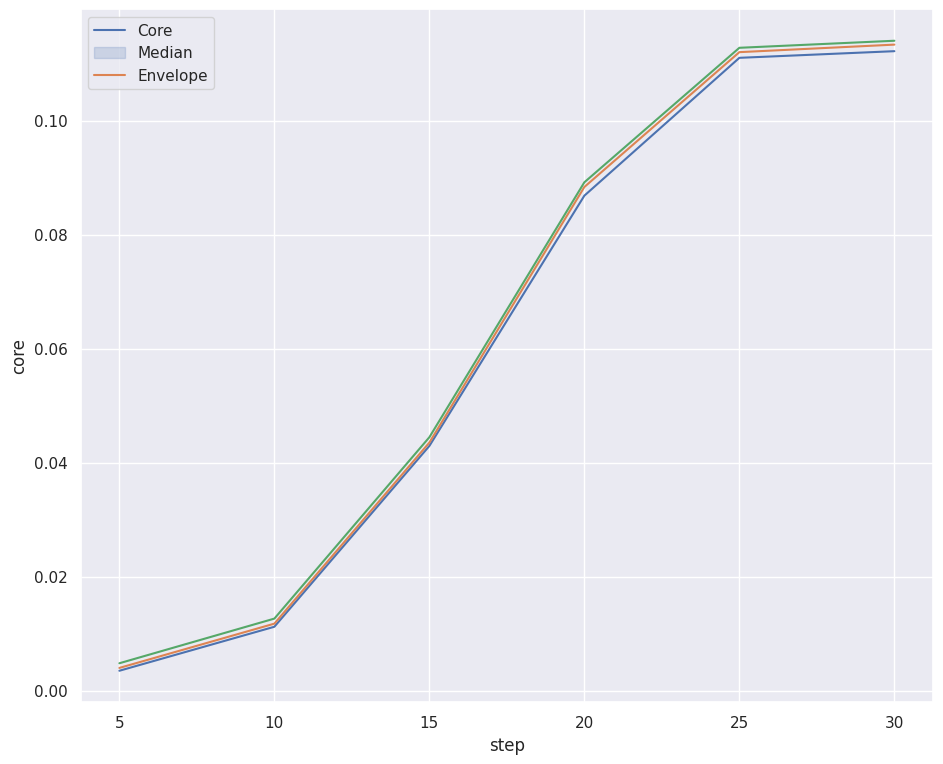

In [283]:
f, ax = plt.subplots(figsize=(11, 9))
sns.lineplot(data=df_samples, x="step", y="core")
sns.lineplot(data=df_samples, x="step", y="median", dashes=True)
sns.lineplot(data=df_samples, x="step", y="envelope")
plt.legend(["Core", "Median", "Envelope"])
plt.show()

In [4]:
gisdb = os.path.join(os.getenv('HOME'), 'grassdata')
# site = 'clay-center'
site = 'SJER'
mapset = 'sensitivity_1'
gj.init(gisdb, site, mapset)

In [ ]:
# Clay Center 3D
# Perspective: 30 
# Height: 22 
# Z-exag 100
# Tilt: 0
# Direction: SW (235)
# Light Direction: (235)
# Light Height: 80

def wave_animation_3d():
    model_spatial_res_params = ["1", "3", "5", "10", "30"]  # meters
    model_particle_density_scalar_params = ["025", "05", "1", "2", "4"]
    # model_particle_density_scalar_params = ["4"]

    methods = "average" #median,minimum,min_raster,maximum,max_raster,stddev,range"
    dataframe_list = []
    output_type = 'depth'
    for res in model_spatial_res_params:
        gs.run_command("g.region", raster=f"elevation_{res}", flags="a")
        for scalar_str in model_particle_density_scalar_params:
            for method in methods.split(","):
                depth_average = f"{output_type}_{res}_{scalar_str}_s_{method}"
                raster_depth_list = gs.parse_command(
                    "t.rast.list",
                    input=depth_average,
                    format="json"
                )
                raster_depth_list= [m['name'] for m in raster_depth_list['data']]
                output_pngs = []
                time_steps = get_agg_simwe_time_steps(f"{output_type}_{res}_{scalar_str}_s_*_{method}")
                # print(time_steps)
                for step in time_steps:
                    PROJECT_MAPSET = "sensitivity_1"
                    raster_map = f"depth_{res}_{scalar_str}_s_{step}_{method}"
                    output_image = f"../output/{site}/{PROJECT_MAPSET}/{site}_wave_depth_3d_{res}_{scalar_str}_s_{step}_{method}.png"
                    elevation_3dmap = gj.Map3D(width=800, height=600, filename=output_image, use_region=True)

                    # Full list of options m.nviz.image
                    # https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
                    elevation_3dmap.render(
                        elevation_map=raster_map,
                        color_map=raster_map,
                        mode="fine",
                        resolution_fine=1,
                        # perspective=20, # Clay-Center
                        # position=0.10,0.91,
                        # height=22, # Clay-Center
                        perspective=20, # SJER
                        # position=0.10,0.91,
                        height=13, # SJER
                        zexag=100,
                        twist=0,
                        focus="454,387,0", # SJER
                        # focus="688,580,0",
                        # bgcolor="255:255:255",
                        # fringe=['ne','nw','sw','se'],
                        # fringe_elevation=-0.5,
                        # light_position="0.85,1.0,0.80",  # Clay-Center
                        light_position="0.7,1.0,0.80", # SJER
                        light_brightness=80,
                        # light_ambient=20,
                        # light_color="255:255:255",
                        arrow_position=[100,50]
                    )
                    
                    try:
                        elevation_3dmap.overlay.d_legend(raster=raster_map, flags="l", at=(60, 97, 87, 92))
                    except:
                        elevation_3dmap.overlay.d_legend(raster=raster_map, flags="", at=(60, 97, 87, 92))
                    output_pngs.append(output_image)

                create_webp_animation(output_pngs, f"../output/{site}/{PROJECT_MAPSET}/{site}_wave_depth_3d_{res}_{scalar_str}_s_{method}.webp", fps=1, loop=0)

wave_animation_3d()


Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_1_025_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_1_05_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_1_1_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_1_2_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_1_4_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_3_025_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_3_05_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_3_1_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_3_2_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_3_4_s_average.webp
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_wave_depth_3d_5_025_s_average.webp
An